# **Feature Engineering**

## Objectives

* Engineer Features for Classification model
  * Investigate the data and decide which steps to include in the feature engineering pipeline
  
## Inputs

* The cleaned train and test sets:
  * outputs/datasets/cleaned/train-set-clean.csv
  * outputs/datasets/cleaned/test-set-clean.csv

## Outputs

* Feature Engineering Transformers and lists of variables to engineer

---

# Import Packages for Feature Engineering

In [44]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from feature_engine.outliers import Winsorizer
from feature_engine import transformation as vt
from feature_engine.selection import SmartCorrelatedSelection

%matplotlib inline

# Change working directory

We need to change the working directory from its current folder to its parent folder
* Access current directory with os.getcwd()

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/ML-maternal-health-risk/jupyter_notebooks'

Make the parent of the current directory the new current directory, and confirm new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory
* os.getcwd() get the current directory

In [4]:
os.chdir(os.path.dirname(current_dir))
current_dir = os.getcwd()
print(f"New current directory set to {current_dir}.")

New current directory set to /workspaces/ML-maternal-health-risk.


# Load Data from cleaned train and test sets

In [5]:
train_set = pd.read_csv('outputs/datasets/cleaned/train-set-clean.csv')
print(train_set.shape)
train_set.head()

(808, 7)


,Age,SystolicBP,DiastolicBP,BloodSugar,BodyTemp,HeartRate,RiskLevel
0,20,120,75,7.01,37.8,70,1
1,30,120,80,9.00,38.3,76,1
2,18,100,70,6.70,36.7,76,0
3,49,140,90,15.00,36.7,90,2
4,28,120,90,6.90,36.7,70,0


In [6]:
test_set = pd.read_csv('outputs/datasets/cleaned/test-set-clean.csv')
print(test_set.shape)
test_set.head()

(203, 7)


,Age,SystolicBP,DiastolicBP,BloodSugar,BodyTemp,HeartRate,RiskLevel
0,19,120,80,7.0,36.7,70,1
1,35,90,65,6.9,36.7,75,0
2,18,90,60,6.9,36.7,70,1
3,35,140,80,13.0,36.7,70,2
4,15,76,49,7.5,36.7,77,0


---

# Data Exploration

The goal of this notebook is to decide which transformations to perform on our features.

We already know that no categorical encoding is needed and that we will include Smart Correlation Selection (see below for more details). What is left to investigate is whether we will perform any numerical transformations of the features to make the distributions closer to a normal distribution.

Let us plot the distributions of the features again, to remind ourselves of the shapes of the distributions.

In [7]:
train_set.head()

,Age,SystolicBP,DiastolicBP,BloodSugar,BodyTemp,HeartRate,RiskLevel
0,20,120,75,7.01,37.8,70,1
1,30,120,80,9.00,38.3,76,1
2,18,100,70,6.70,36.7,76,0
3,49,140,90,15.00,36.7,90,2
4,28,120,90,6.90,36.7,70,0


Plot distributions of all features:

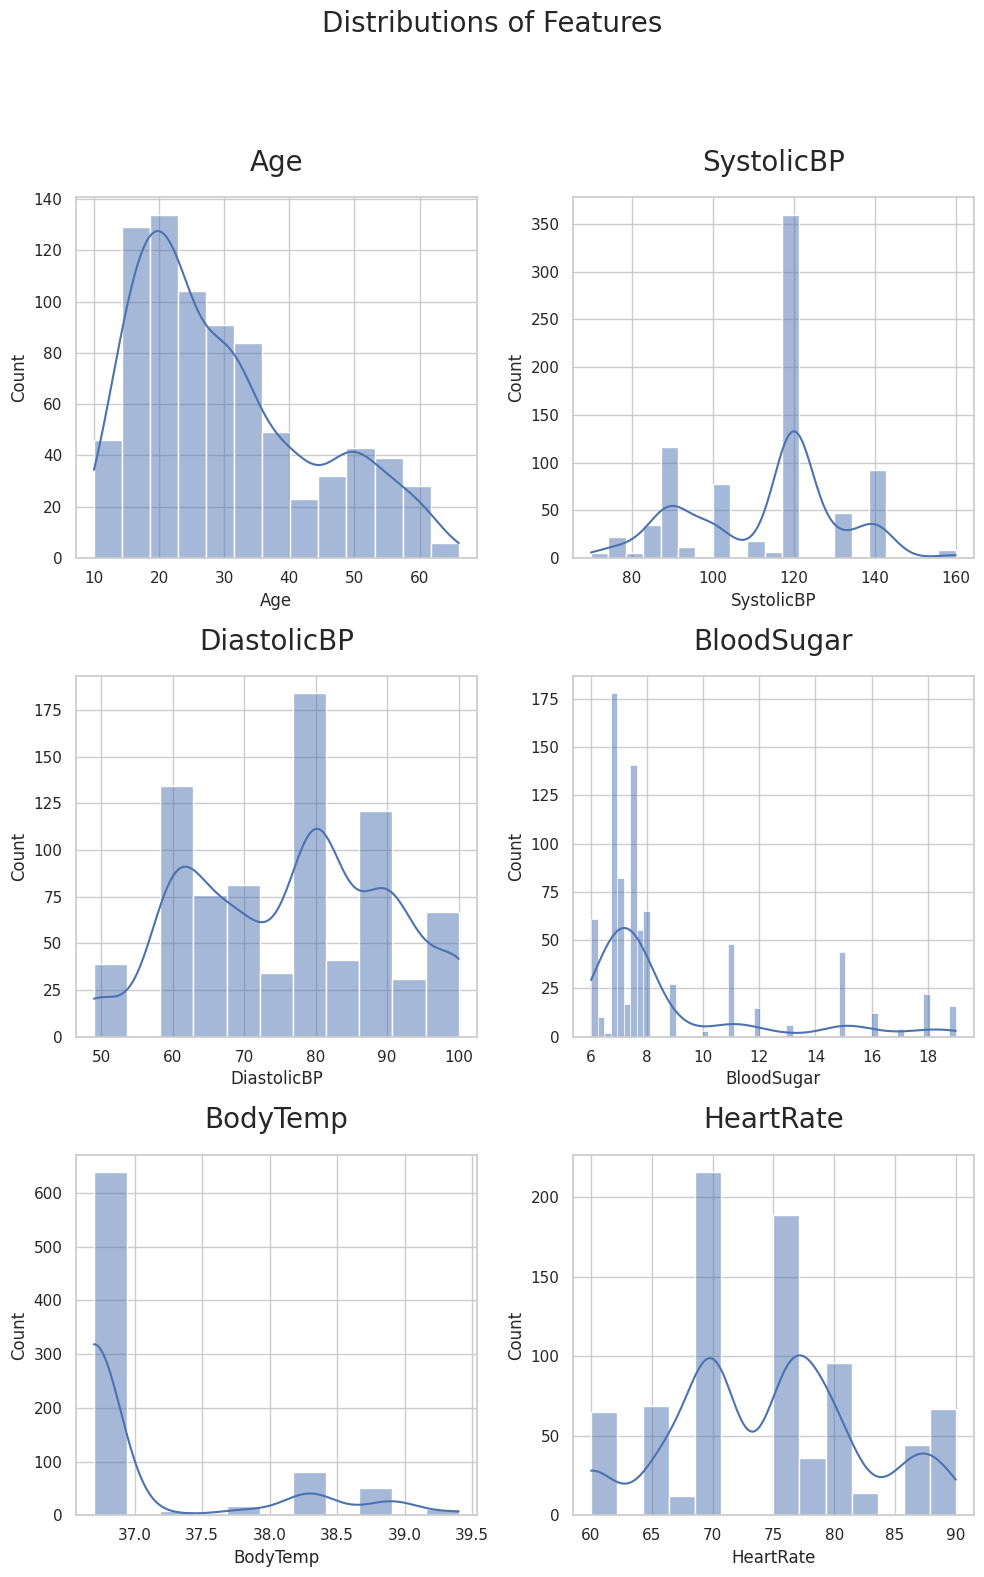

In [39]:
cols = train_set.columns.to_list()

sns.set_theme(style="whitegrid")

fig_distr, axes = plt.subplots(3, 2, figsize=(10, 15))
fig_distr.suptitle("Distributions of Features", fontsize=20, y=1.05)

# define index list:
ind_list = []
for i in range(3):
    for j in range(2):
        ind_list.append([i,j])

for ind, var in enumerate(cols[:-1]):
    i, j = ind_list[ind]
    sns.histplot(ax=axes[i, j], data=train_set, x=var, kde=True, element="bars")
    axes[i, j].set_title(f"{var}", fontsize=20, y=1.05)

    plt.tight_layout()

## Feature Engineering Custom Function

* A custom function that quickly applies different feature transformations and reports the results
* A winsorizer transformation is performed to handle outliers
* Six different numerical transformations are performed for each feature (log_e, log_10, reciprocal, power, box_cox, yeo_johnson)
* The distributions, QQ plot and boxplot are shown before and after transformation
* Skewness and kurtosis are calculated before and after transformations
* These details should help decide whether any of these transformations could be helpful

In [68]:
# Code for this custom function was inspired by the Code Institute Churnometer 
# walkthrough project
# The function was adapted to this project, where we are only interested in
# outlier handling with winsorizer and possible numerical transformations
# The skewness and kurtosis before and after transformations is included as well
# A skewness and kurtosis report is generated and stored in a dataframe

sns.set_theme(style="whitegrid")

def FeatureEngineeringAnalysis(df, analysis_type=None):
    """
    This function performs feature engineering on numerical variables and
    reports and visualises the results
    Skewness and kurtosis are computed before and after transformations
    and a report is generated and stored in a dataframe
    This helps in deciding which transformations might better transform the 
    distribution shape
    """
    # check for missing values to be sure
    check_missing_values(df)
    allowed_types = ['numerical', 'outlier_winsorizer']
    check_user_entry_on_analysis_type(analysis_type, allowed_types)
    list_column_transformers = define_list_column_transformers(analysis_type)

    # create a skew_kurtosis_report for all columns and transformations as a summary
    skew_kurtosis_report = pd.DataFrame([])

    # Loop in each variable and engineer the data according to the analysis type
    df_feat_eng = pd.DataFrame([])
    for column in df.columns:
        # create additional columns (column_method) to apply the methods
        df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
        for method in list_column_transformers:
            df_feat_eng[f"{column}_{method}"] = df[column]

        # Apply transformers in respective column_transformers
        df_feat_eng, list_applied_transformers = apply_transformers(
                                                    analysis_type,
                                                    df_feat_eng,
                                                    column
                                                )

        # For each variable, assess how the transformations perform
        # Code to create report as dataframe
        skew_kurtosis_report_col = transformer_evaluation(
                                        column,
                                        list_applied_transformers,
                                        analysis_type,
                                        df_feat_eng
                                        )
        skew_kurtosis_report = pd.concat([
                                    skew_kurtosis_report,
                                    skew_kurtosis_report_col
                                    ])

    # return a skew kurtosis report as a dataframe
    return df_feat_eng, skew_kurtosis_report.reset_index(drop=True)


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
    """ Check analysis type """
    if analysis_type is None:
        raise SystemExit(
            "You should pass analysis_type parameter as one of the following "
            f"options: {allowed_types}"
            )
    if analysis_type not in allowed_types:
        raise SystemExit(
            "Analysis_type argument should be one of these options: "
            f" {allowed_types}"
            )


def check_missing_values(df):
    if df.isna().sum().sum() != 0:
        raise SystemExit(
            "There is a missing value in your dataset. "
            "Please handle that before getting into feature engineering."
            )


def define_list_column_transformers(analysis_type):
    """ Set suffix columns according to analysis_type"""
    if analysis_type == 'numerical':
        list_column_transformers = [
            "log_e", "log_10", "reciprocal", "power", "box_cox", "yeo_johnson"]

    elif analysis_type == 'outlier_winsorizer':
        list_column_transformers = ['iqr']

    return list_column_transformers


def apply_transformers(analysis_type, df_feat_eng, column):
    for col in df_feat_eng.select_dtypes(include='category').columns:
        df_feat_eng[col] = df_feat_eng[col].astype('object')

    if analysis_type == 'numerical':
        df_feat_eng, list_applied_transformers = FeatEngineering_Numerical(
                                                    df_feat_eng,
                                                    column
                                                    )

    elif analysis_type == 'outlier_winsorizer':
        df_feat_eng, list_applied_transformers = FeatEngineering_OutlierWinsorizer(  # noqa
                                                    df_feat_eng,
                                                    column
                                                    )

    return df_feat_eng, list_applied_transformers


def transformer_evaluation(
                        column,
                        list_applied_transformers,
                        analysis_type,
                        df_feat_eng
                        ):
    # For each variable, assess how the transformations perform
    print(f"* Variable Analyzed: {column}")
    print(f"* Applied transformation: {list_applied_transformers} \n")
    skew_kurtosis_report_col = pd.DataFrame([])
    for col in [column] + list_applied_transformers:
        DiagnosticPlots_Numerical(df_feat_eng, col)
        # Code to display skew and kurtosis and add to report
        print(
            f"{col}  | skewness: {df_feat_eng[col].skew().round(2)} | "
            f"kurtosis: {df_feat_eng[col].kurtosis().round(2)}"
            )
        skew_kurtosis = pd.DataFrame({
                            "Feat_Trans": [col],
                            "Skewness": [df_feat_eng[col].skew().round(2)],
                            "Kurtosis": [df_feat_eng[col].kurtosis().round(2)]
                            })
        skew_kurtosis_report_col = pd.concat([
                                        skew_kurtosis_report_col,
                                        skew_kurtosis
                                        ])
        print("\n")
    return skew_kurtosis_report_col


def DiagnosticPlots_Numerical(df, variable):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    sns.histplot(data=df, x=variable, kde=True, element="step", ax=axes[0])
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    sns.boxplot(x=df[variable], ax=axes[2])

    axes[0].set_title('Histogram')
    axes[1].set_title('QQ Plot')
    axes[2].set_title('Boxplot')
    fig.suptitle(f"{variable}", fontsize=30, y=1.05)
    plt.tight_layout()
    plt.show()


def FeatEngineering_OutlierWinsorizer(df_feat_eng, column):
    list_methods_worked = []

    # Winsorizer iqr
    try:
        disc = Winsorizer(
                capping_method='iqr',
                tail='both',
                fold=1.5,
                variables=[f"{column}_iqr"]
                )
        df_feat_eng = disc.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_iqr")
    except Exception:
        df_feat_eng.drop([f"{column}_iqr"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_Numerical(df_feat_eng, column):
    list_methods_worked = []

    # LogTransformer base e
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_e"])
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_e")
    except Exception:
        df_feat_eng.drop([f"{column}_log_e"], axis=1, inplace=True)

    # LogTransformer base 10
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_10"], base='10')
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_10")
    except Exception:
        df_feat_eng.drop([f"{column}_log_10"], axis=1, inplace=True)

    # ReciprocalTransformer
    try:
        rt = vt.ReciprocalTransformer(variables=[f"{column}_reciprocal"])
        df_feat_eng = rt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_reciprocal")
    except Exception:
        df_feat_eng.drop([f"{column}_reciprocal"], axis=1, inplace=True)

    # PowerTransformer
    try:
        pt = vt.PowerTransformer(variables=[f"{column}_power"])
        df_feat_eng = pt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_power")
    except Exception:
        df_feat_eng.drop([f"{column}_power"], axis=1, inplace=True)

    # BoxCoxTransformer
    try:
        bct = vt.BoxCoxTransformer(variables=[f"{column}_box_cox"])
        df_feat_eng = bct.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_box_cox")
    except Exception:
        df_feat_eng.drop([f"{column}_box_cox"], axis=1, inplace=True)

    # YeoJohnsonTransformer
    try:
        yjt = vt.YeoJohnsonTransformer(variables=[f"{column}_yeo_johnson"])
        df_feat_eng = yjt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_yeo_johnson")
    except Exception:
        df_feat_eng.drop([f"{column}_yeo_johnson"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked

Create a copy of the train set excluding the target, to get the data frame for feature engineering analysis

In [46]:
df_eng = train_set.copy()
df_eng.drop(columns="RiskLevel", inplace=True)
df_eng.head()

,Age,SystolicBP,DiastolicBP,BloodSugar,BodyTemp,HeartRate
0,20,120,75,7.01,37.8,70
1,30,120,80,9.00,38.3,76
2,18,100,70,6.70,36.7,76
3,49,140,90,15.00,36.7,90
4,28,120,90,6.90,36.7,70


### Apply Feature Engineering Analysis Function for Numerical Transformations

Note that this figure will be very large, since 6 transformations are tried out on 6 features.

* Variable Analyzed: Age
* Applied transformation: ['Age_log_e', 'Age_log_10', 'Age_reciprocal', 'Age_power', 'Age_box_cox', 'Age_yeo_johnson'] 



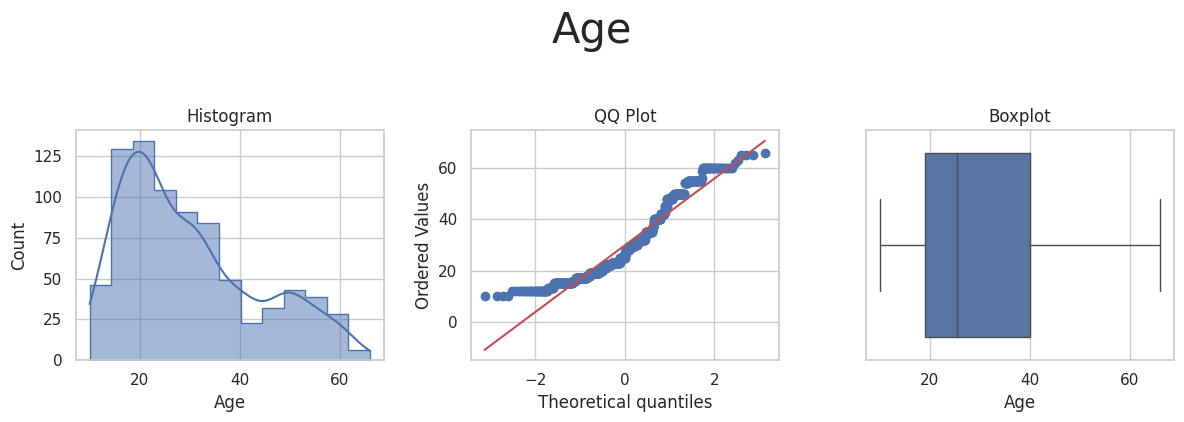

Age  | skewness: 0.75 | kurtosis: -0.47




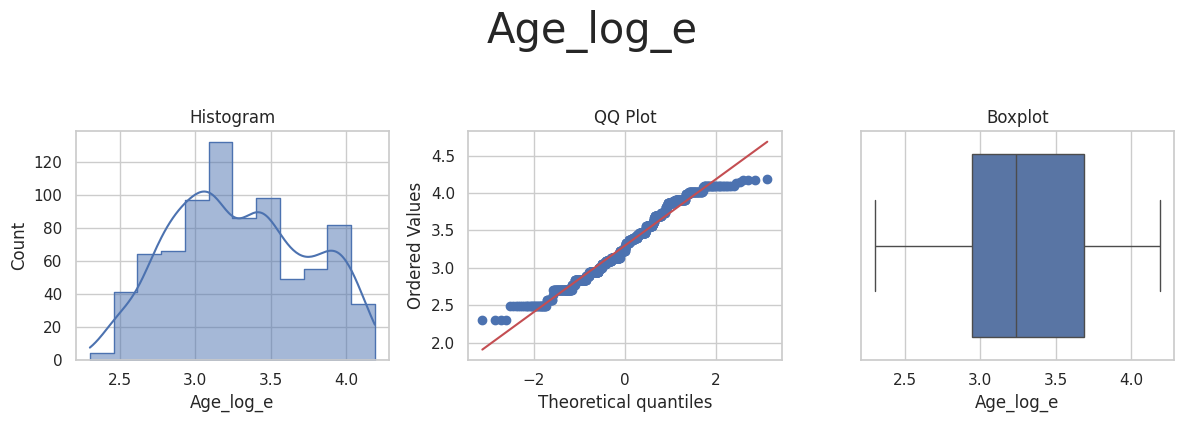

Age_log_e  | skewness: 0.09 | kurtosis: -0.93




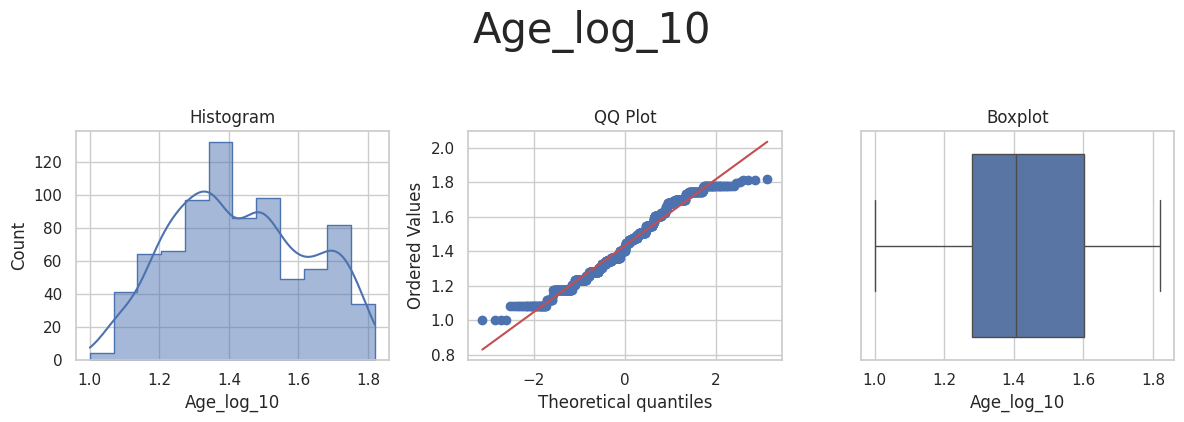

Age_log_10  | skewness: 0.09 | kurtosis: -0.93




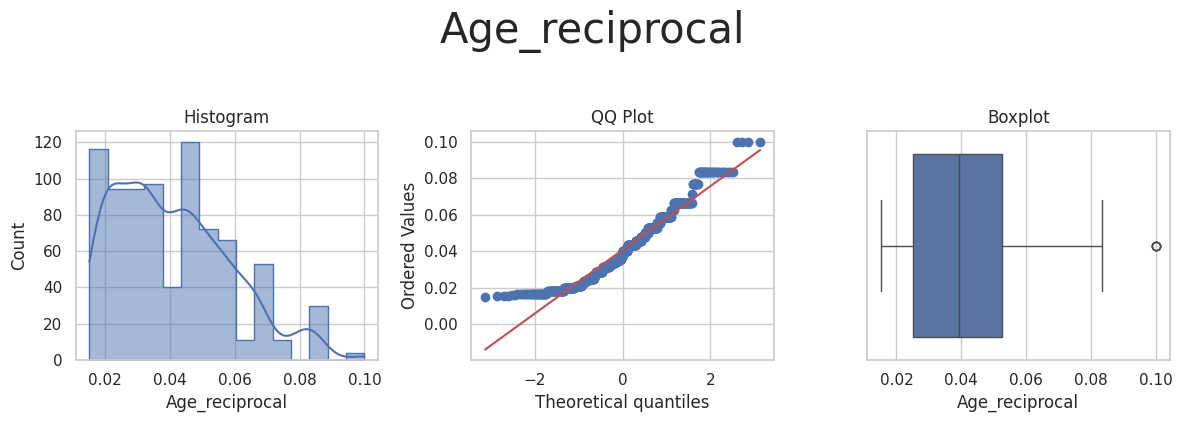

Age_reciprocal  | skewness: 0.68 | kurtosis: -0.07




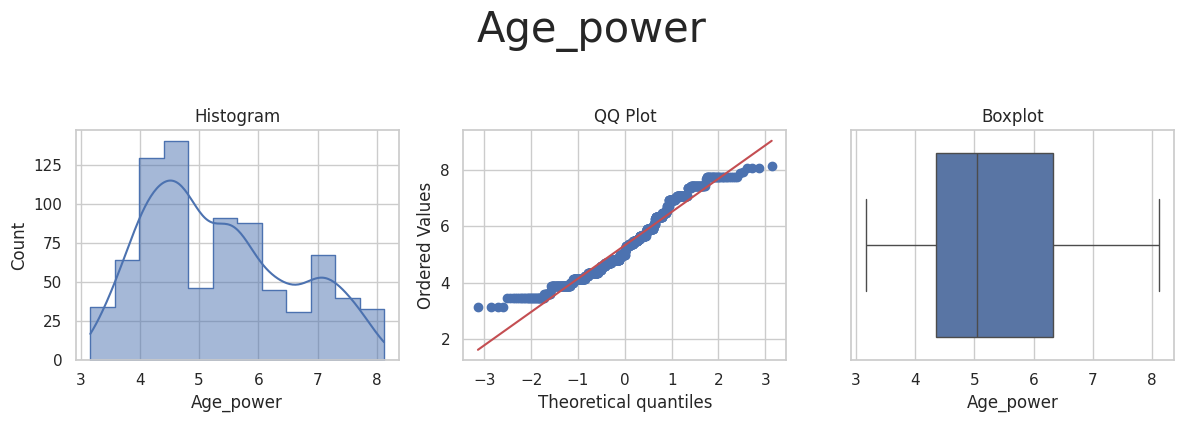

Age_power  | skewness: 0.43 | kurtosis: -0.82




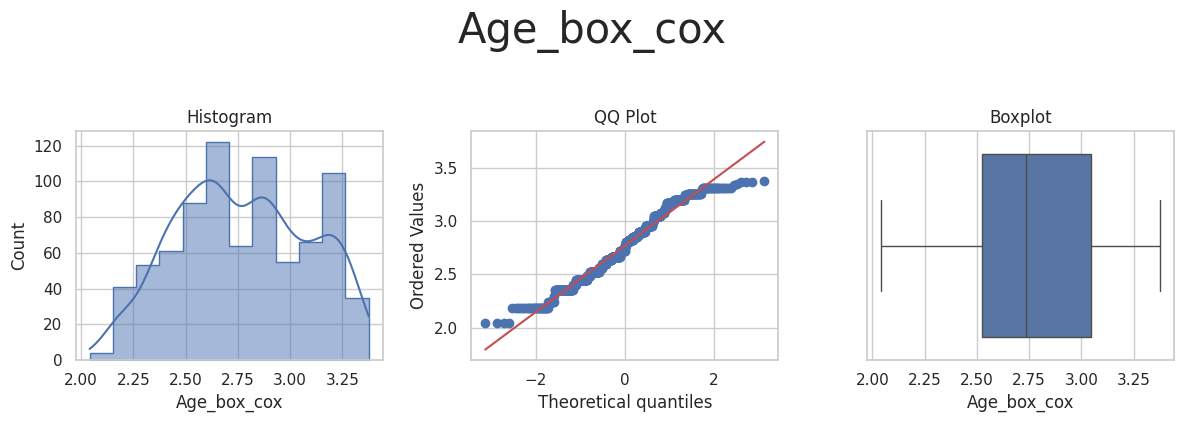

Age_box_cox  | skewness: 0.01 | kurtosis: -0.91




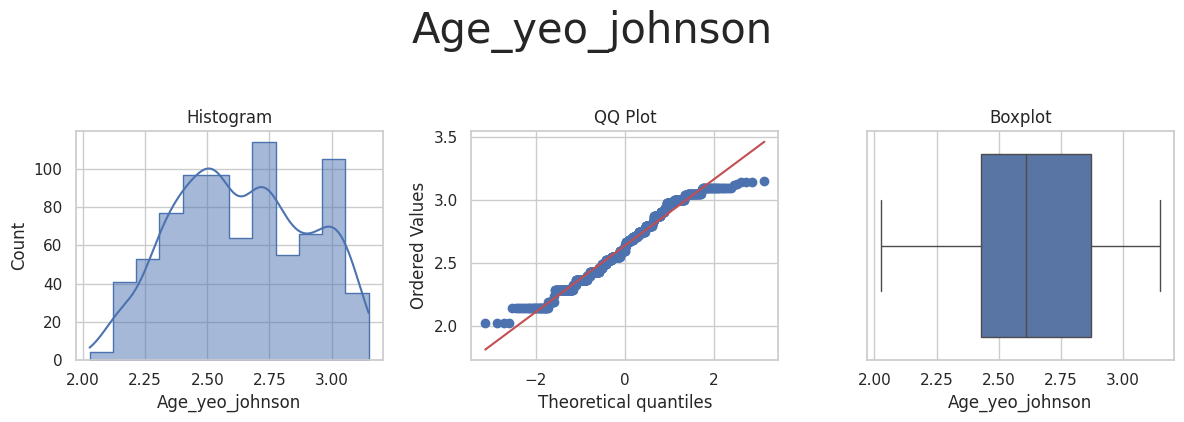

Age_yeo_johnson  | skewness: 0.02 | kurtosis: -0.92


* Variable Analyzed: SystolicBP
* Applied transformation: ['SystolicBP_log_e', 'SystolicBP_log_10', 'SystolicBP_reciprocal', 'SystolicBP_power', 'SystolicBP_box_cox', 'SystolicBP_yeo_johnson'] 



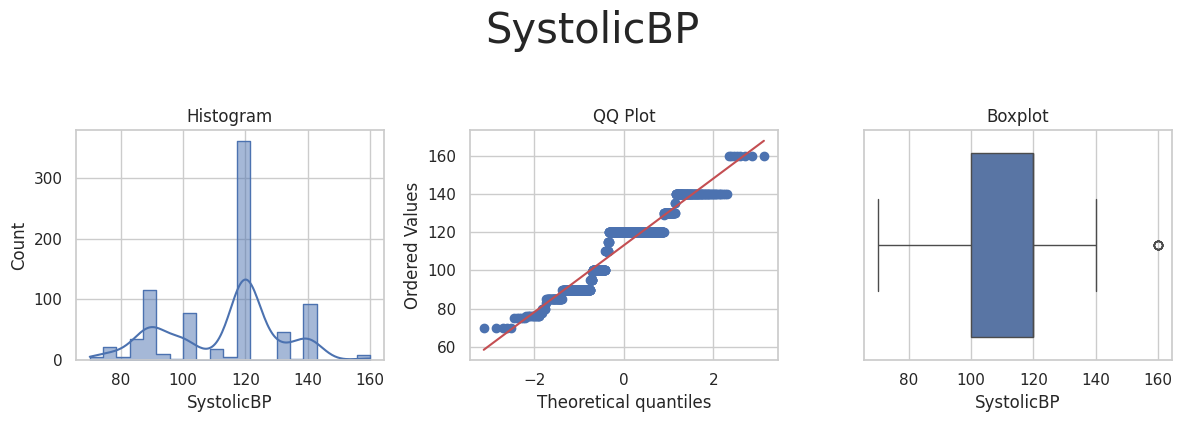

SystolicBP  | skewness: -0.25 | kurtosis: -0.57




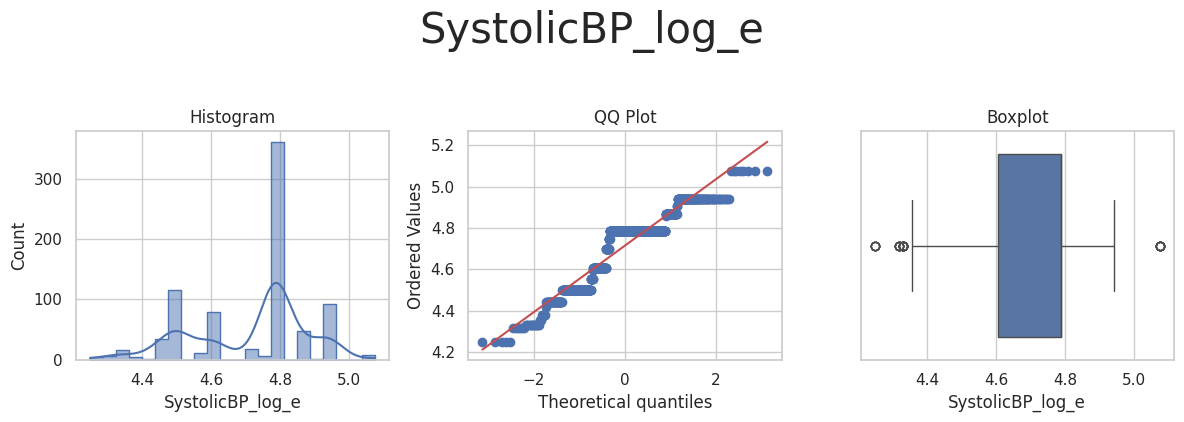

SystolicBP_log_e  | skewness: -0.57 | kurtosis: -0.46




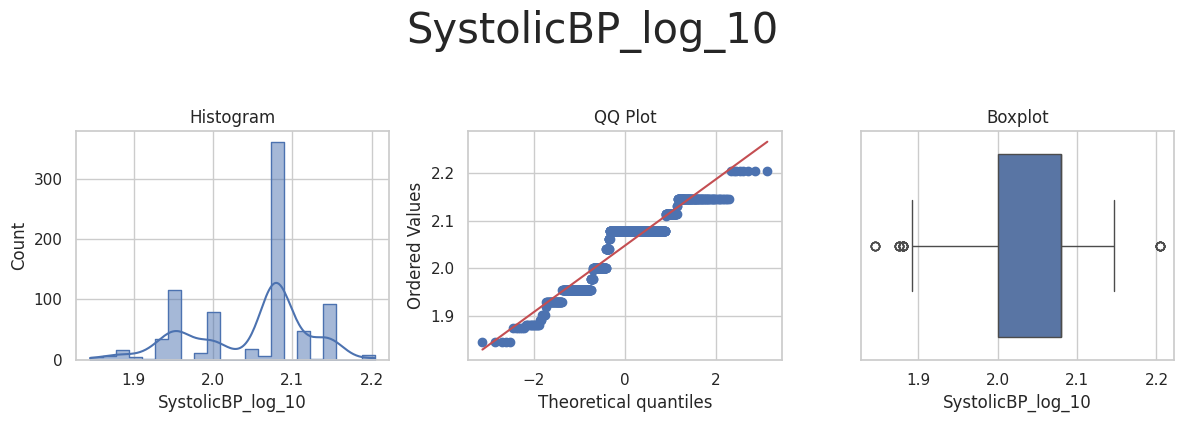

SystolicBP_log_10  | skewness: -0.57 | kurtosis: -0.46




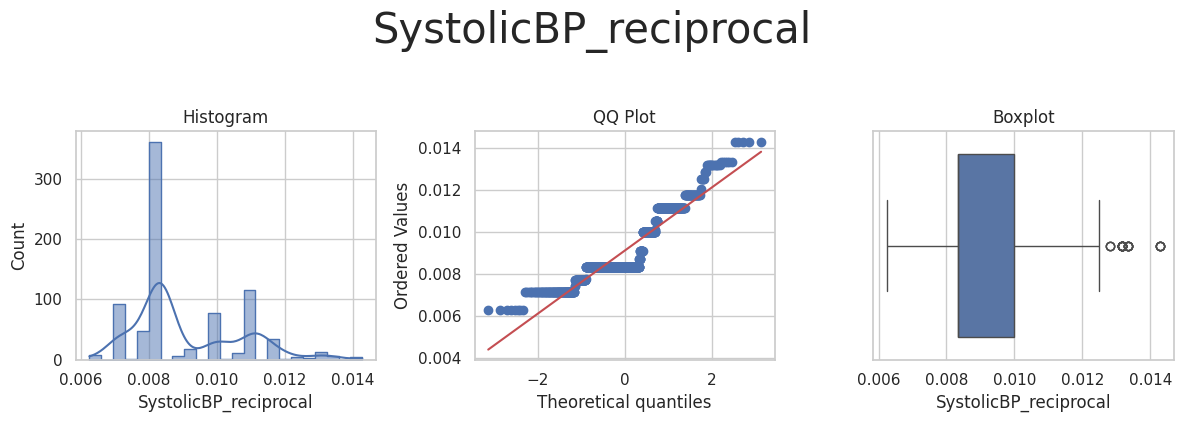

SystolicBP_reciprocal  | skewness: 0.87 | kurtosis: 0.03




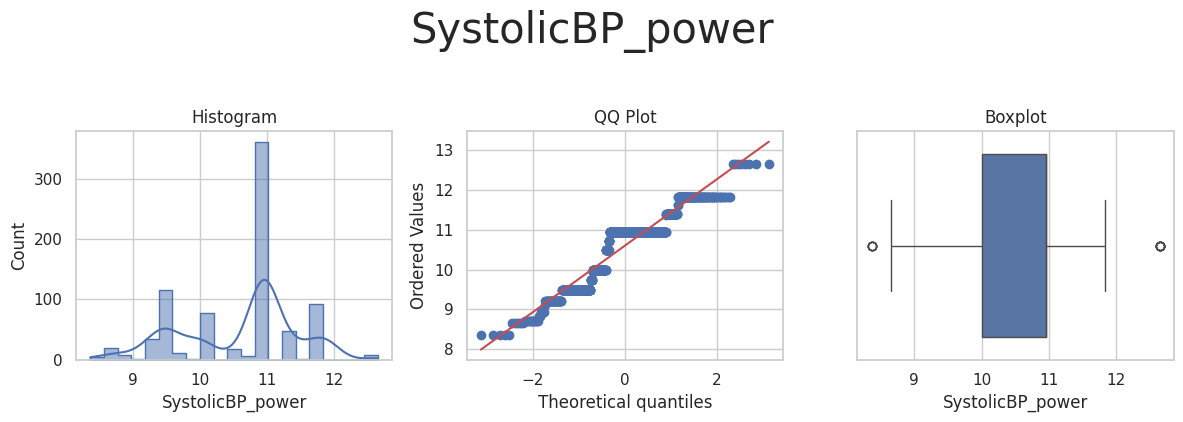

SystolicBP_power  | skewness: -0.41 | kurtosis: -0.56




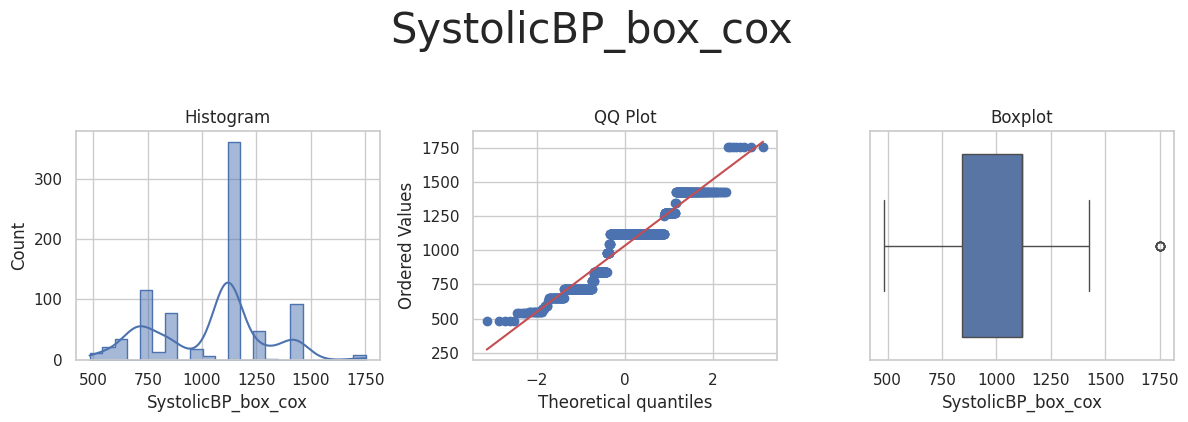

SystolicBP_box_cox  | skewness: -0.06 | kurtosis: -0.47




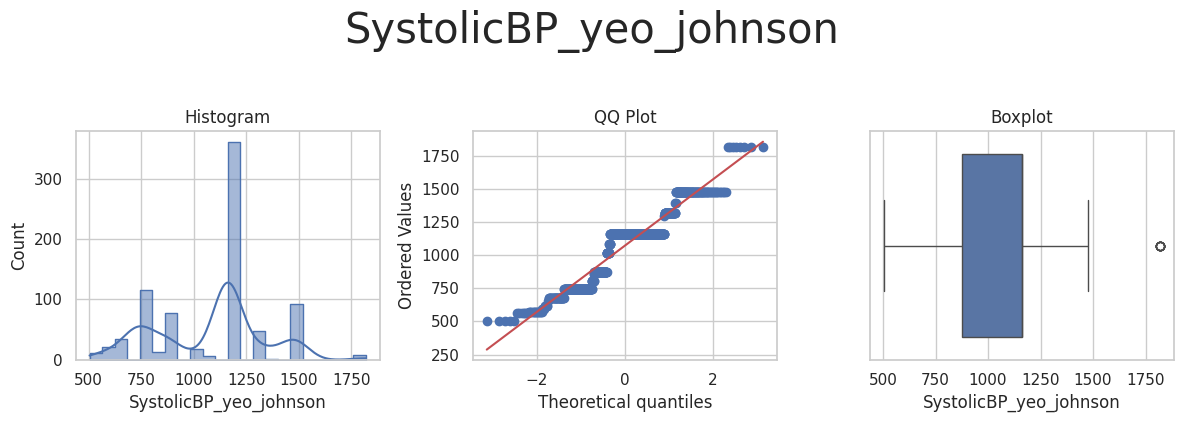

SystolicBP_yeo_johnson  | skewness: -0.06 | kurtosis: -0.47


* Variable Analyzed: DiastolicBP
* Applied transformation: ['DiastolicBP_log_e', 'DiastolicBP_log_10', 'DiastolicBP_reciprocal', 'DiastolicBP_power', 'DiastolicBP_box_cox', 'DiastolicBP_yeo_johnson'] 



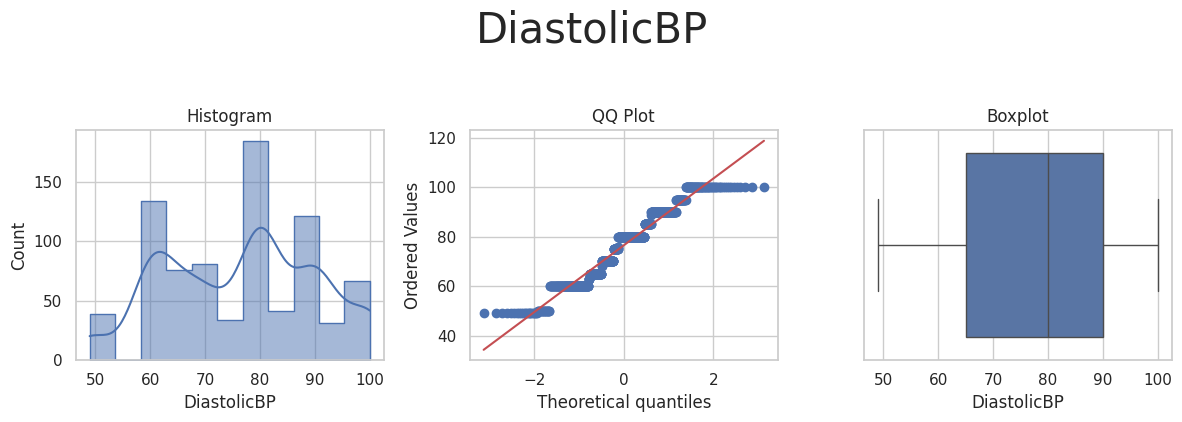

DiastolicBP  | skewness: -0.07 | kurtosis: -0.92




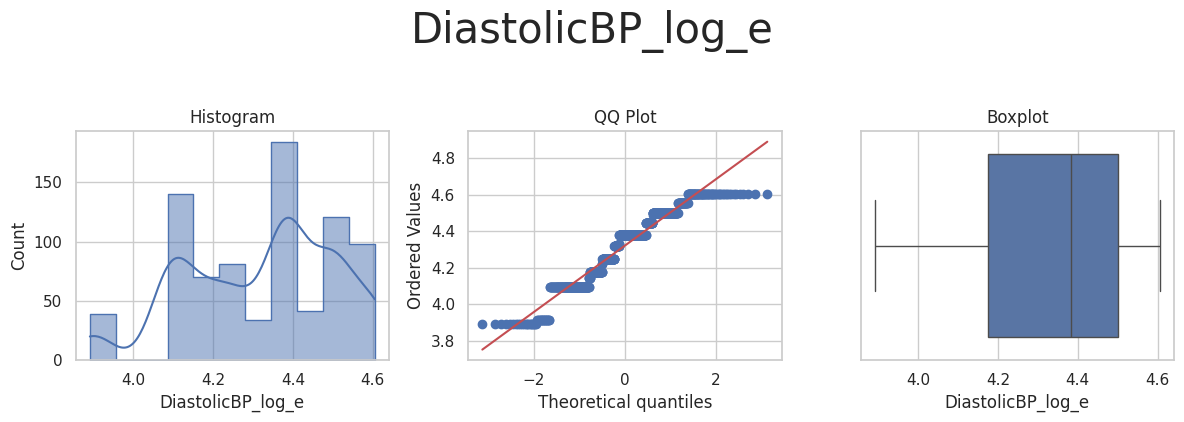

DiastolicBP_log_e  | skewness: -0.38 | kurtosis: -0.68




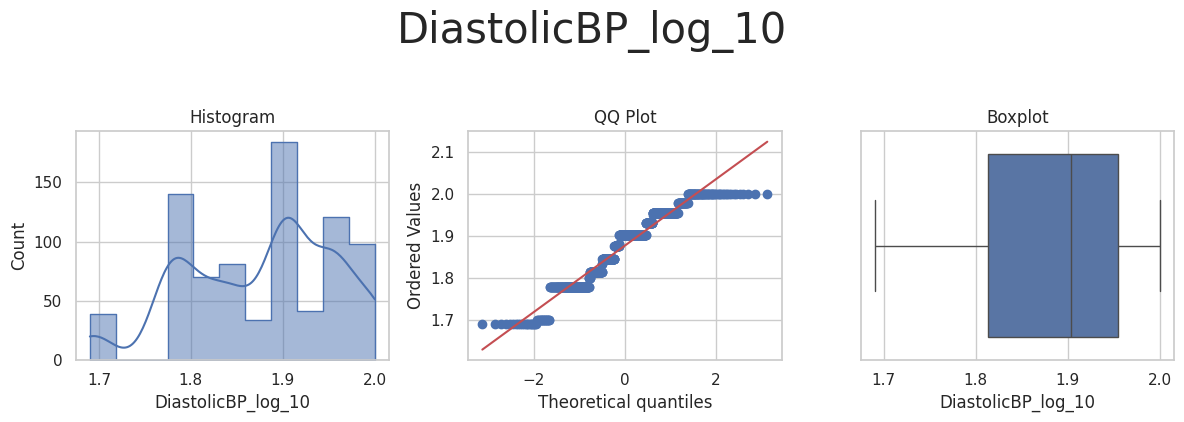

DiastolicBP_log_10  | skewness: -0.38 | kurtosis: -0.68




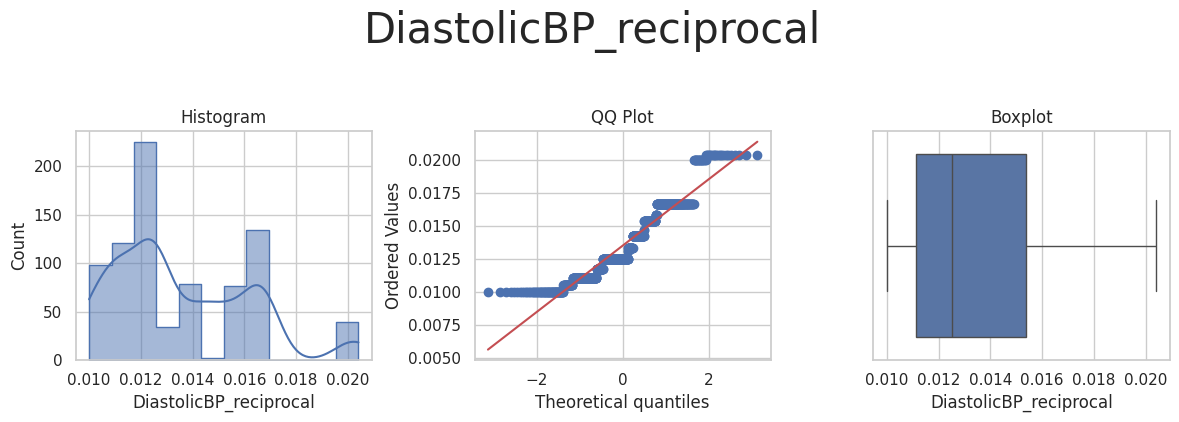

DiastolicBP_reciprocal  | skewness: 0.73 | kurtosis: -0.08




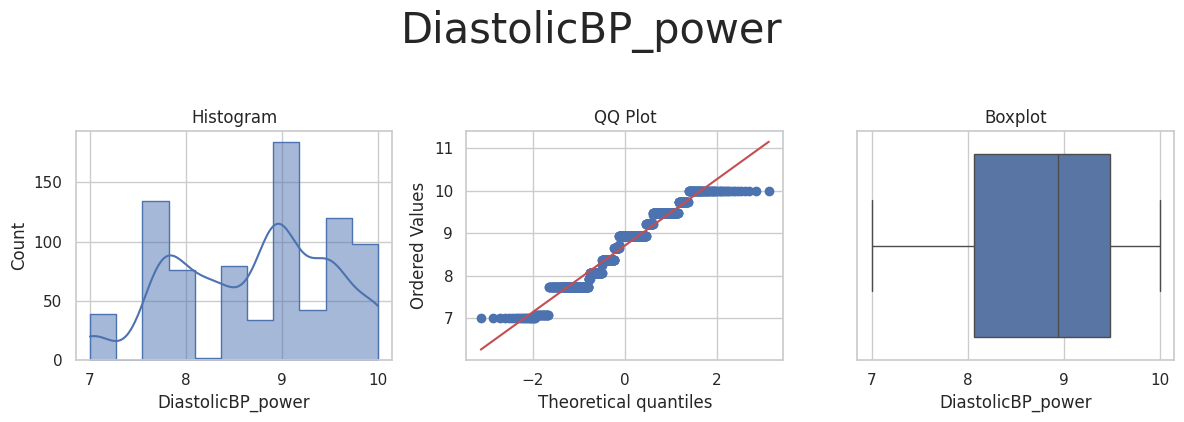

DiastolicBP_power  | skewness: -0.22 | kurtosis: -0.84




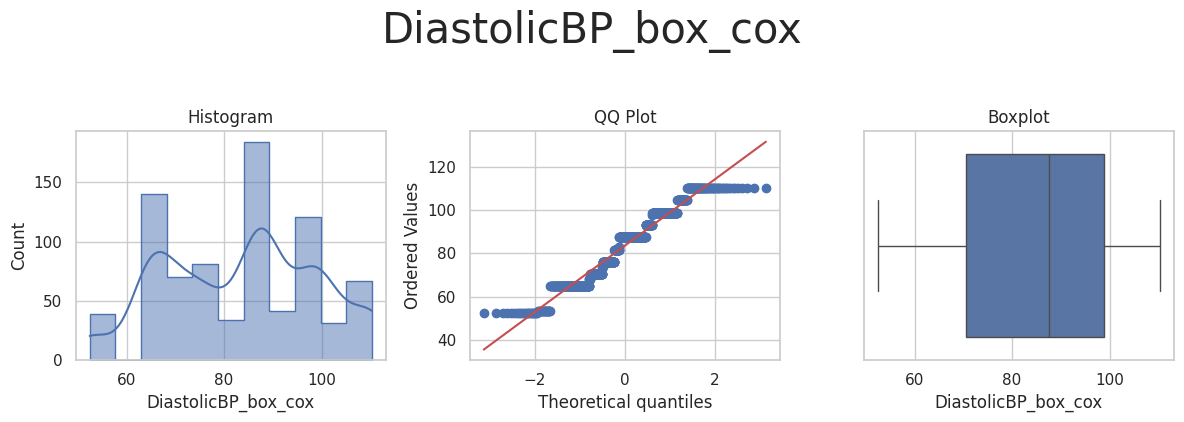

DiastolicBP_box_cox  | skewness: -0.06 | kurtosis: -0.93




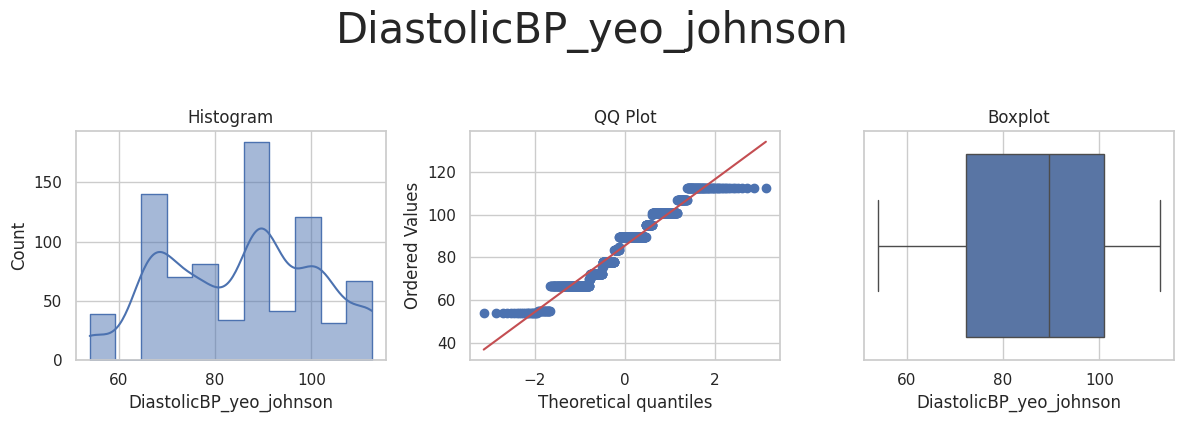

DiastolicBP_yeo_johnson  | skewness: -0.06 | kurtosis: -0.93


* Variable Analyzed: BloodSugar
* Applied transformation: ['BloodSugar_log_e', 'BloodSugar_log_10', 'BloodSugar_reciprocal', 'BloodSugar_power', 'BloodSugar_box_cox', 'BloodSugar_yeo_johnson'] 



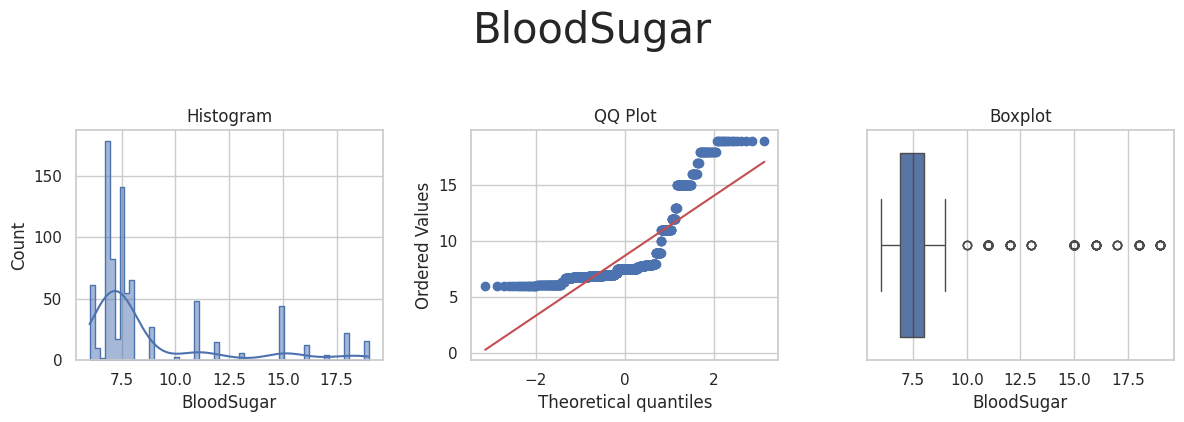

BloodSugar  | skewness: 1.87 | kurtosis: 2.39




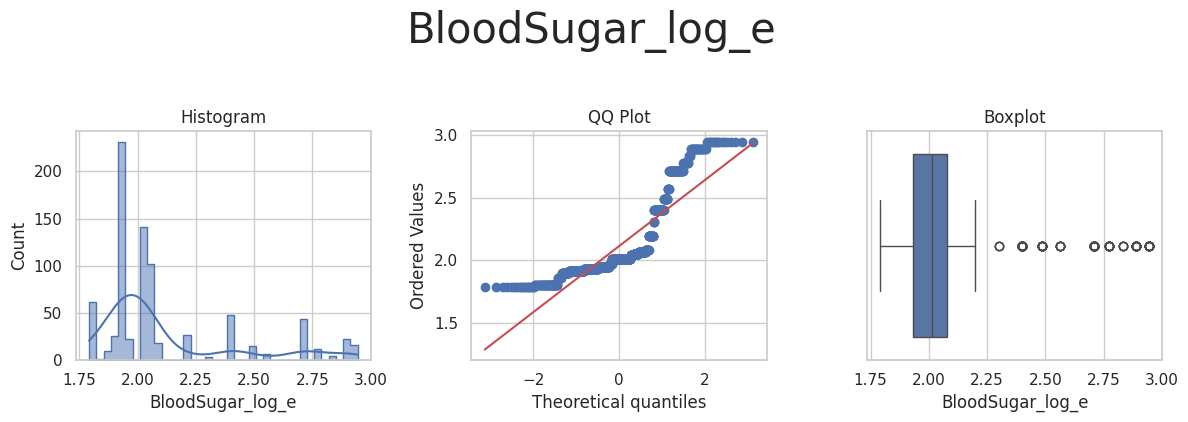

BloodSugar_log_e  | skewness: 1.5 | kurtosis: 1.1




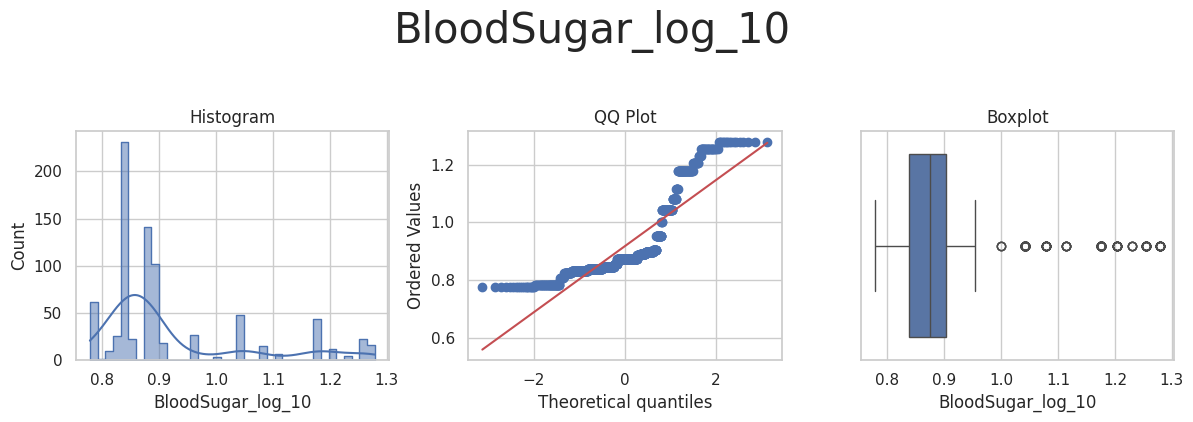

BloodSugar_log_10  | skewness: 1.5 | kurtosis: 1.1




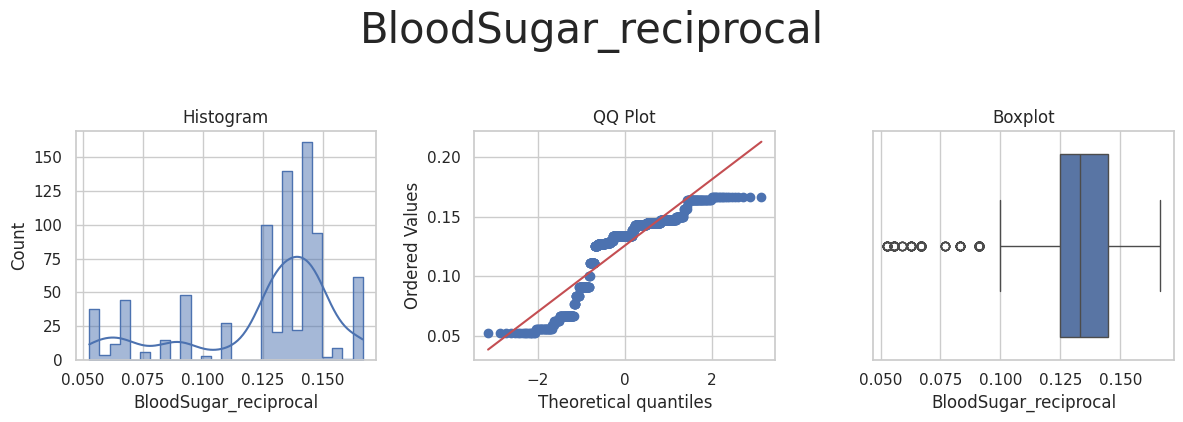

BloodSugar_reciprocal  | skewness: -1.12 | kurtosis: 0.19




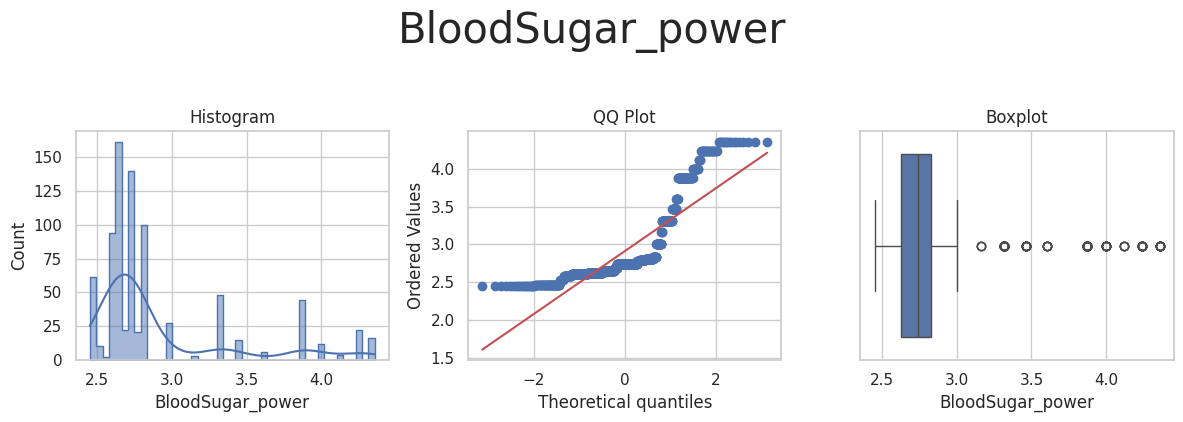

BloodSugar_power  | skewness: 1.69 | kurtosis: 1.69




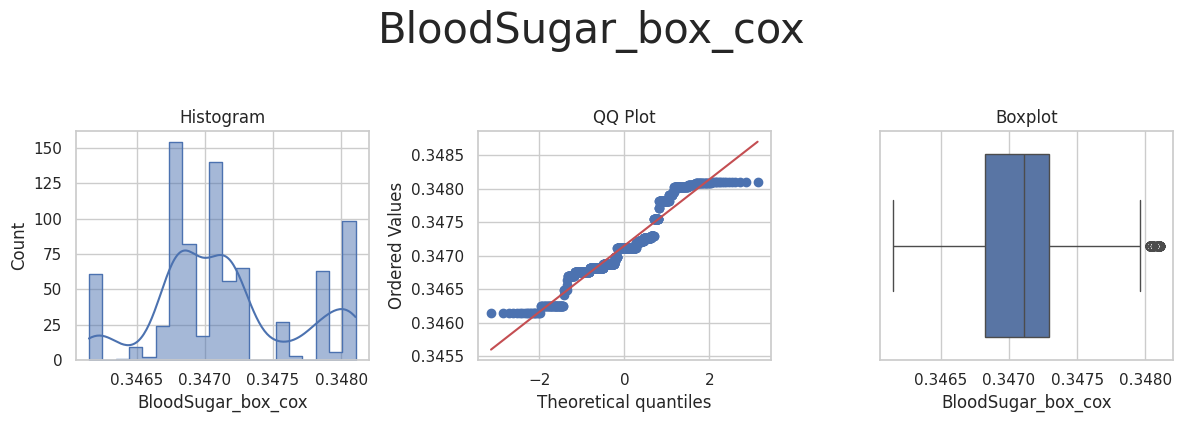

BloodSugar_box_cox  | skewness: 0.34 | kurtosis: -0.47




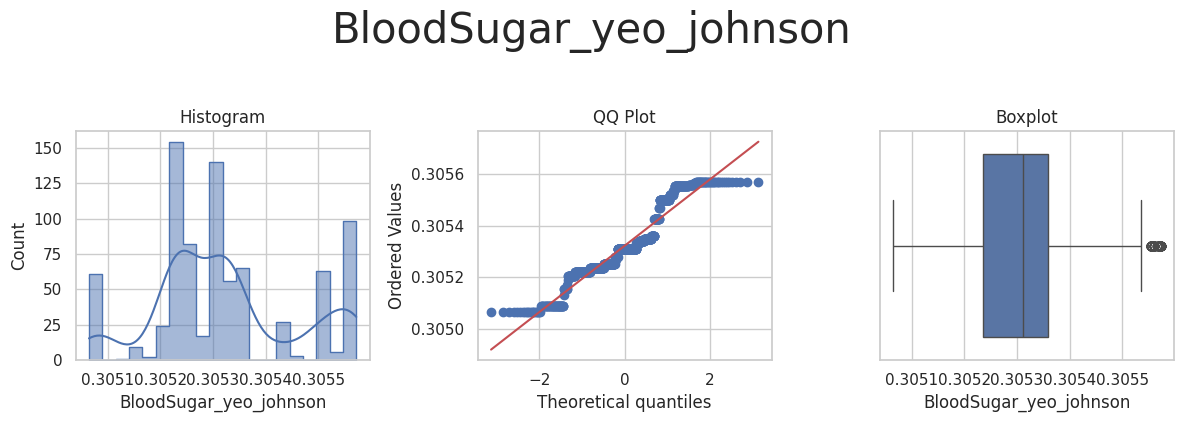

BloodSugar_yeo_johnson  | skewness: 0.36 | kurtosis: -0.49


* Variable Analyzed: BodyTemp
* Applied transformation: ['BodyTemp_log_e', 'BodyTemp_log_10', 'BodyTemp_reciprocal', 'BodyTemp_power', 'BodyTemp_box_cox', 'BodyTemp_yeo_johnson'] 



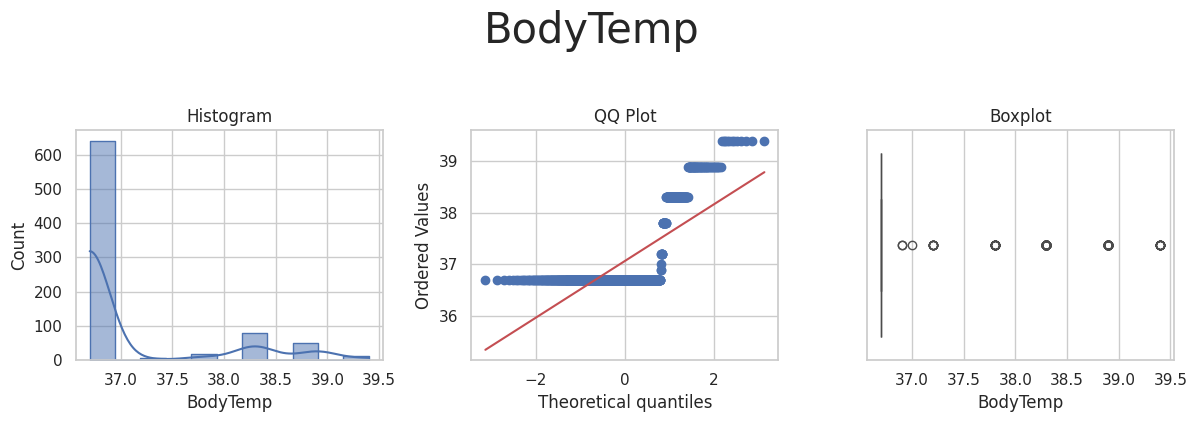

BodyTemp  | skewness: 1.74 | kurtosis: 1.46




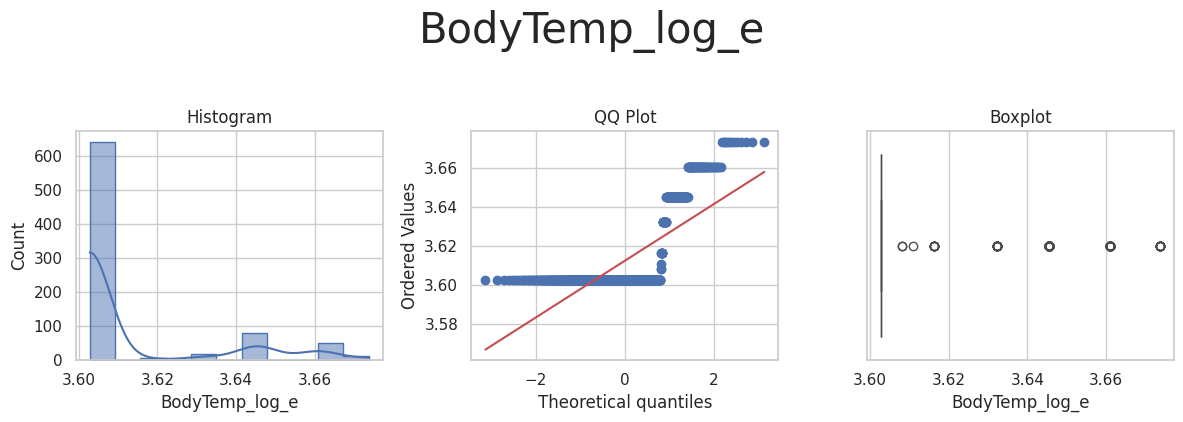

BodyTemp_log_e  | skewness: 1.73 | kurtosis: 1.4




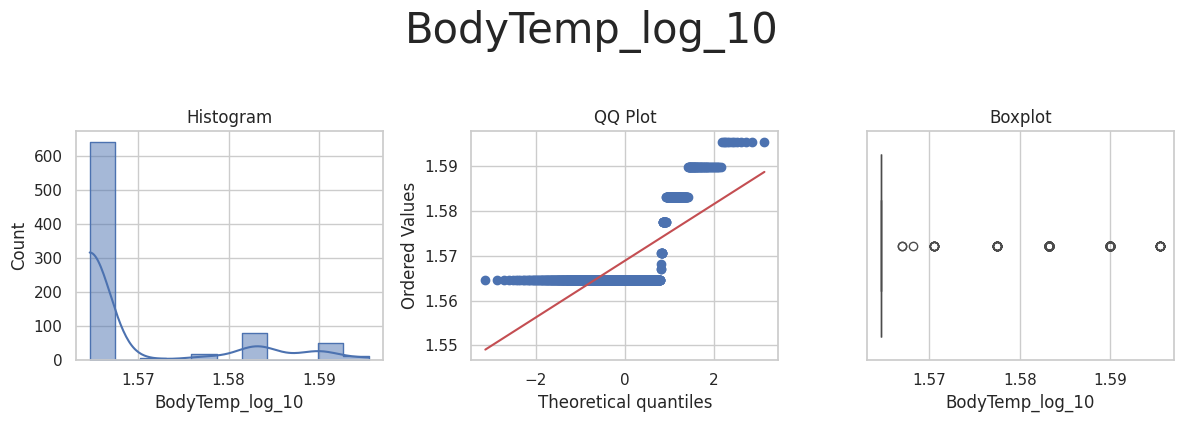

BodyTemp_log_10  | skewness: 1.73 | kurtosis: 1.4




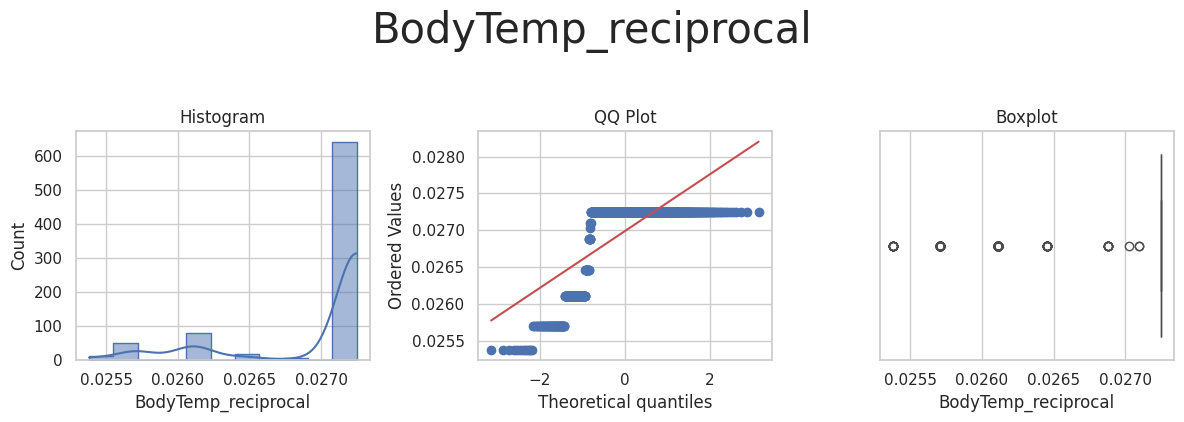

BodyTemp_reciprocal  | skewness: -1.72 | kurtosis: 1.34




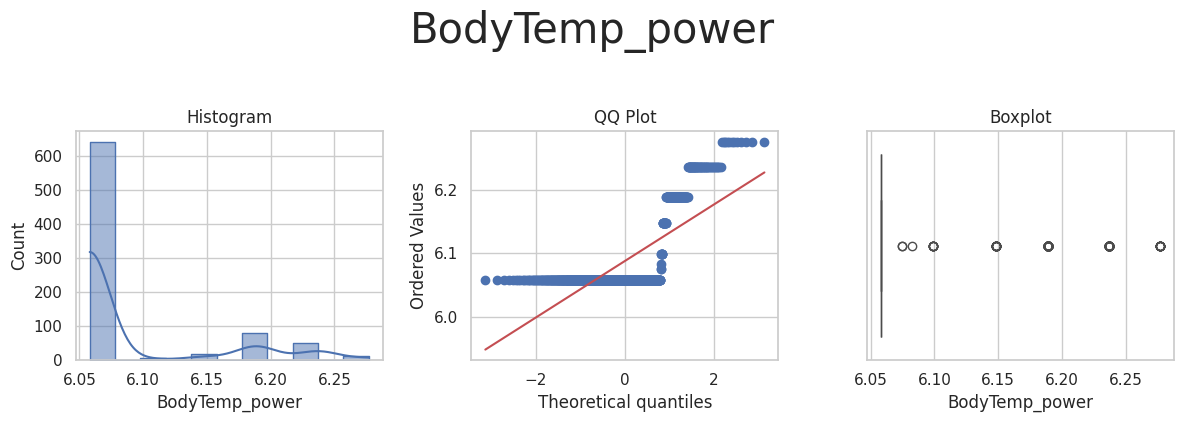

BodyTemp_power  | skewness: 1.74 | kurtosis: 1.43




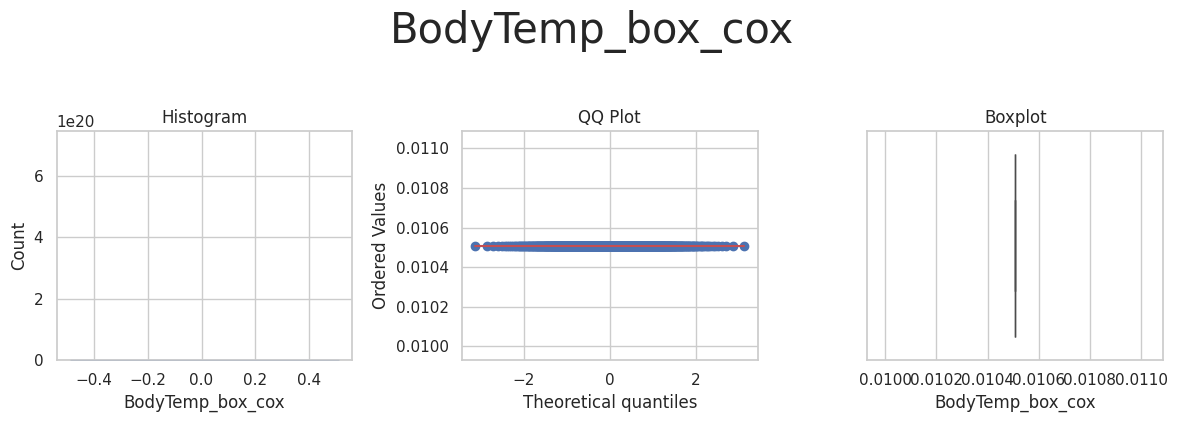

BodyTemp_box_cox  | skewness: 0.0 | kurtosis: 0.0




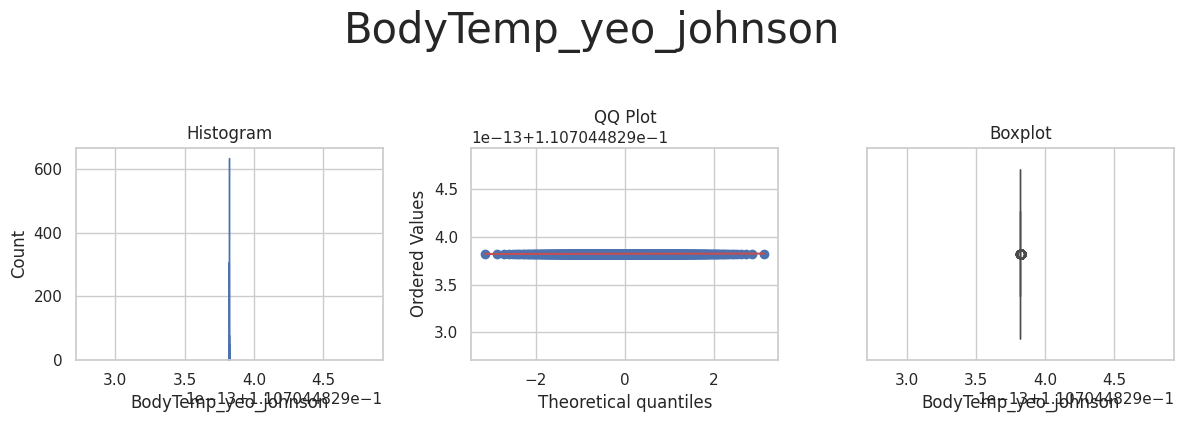

BodyTemp_yeo_johnson  | skewness: 0.0 | kurtosis: 0.0


* Variable Analyzed: HeartRate
* Applied transformation: ['HeartRate_log_e', 'HeartRate_log_10', 'HeartRate_reciprocal', 'HeartRate_power', 'HeartRate_box_cox', 'HeartRate_yeo_johnson'] 



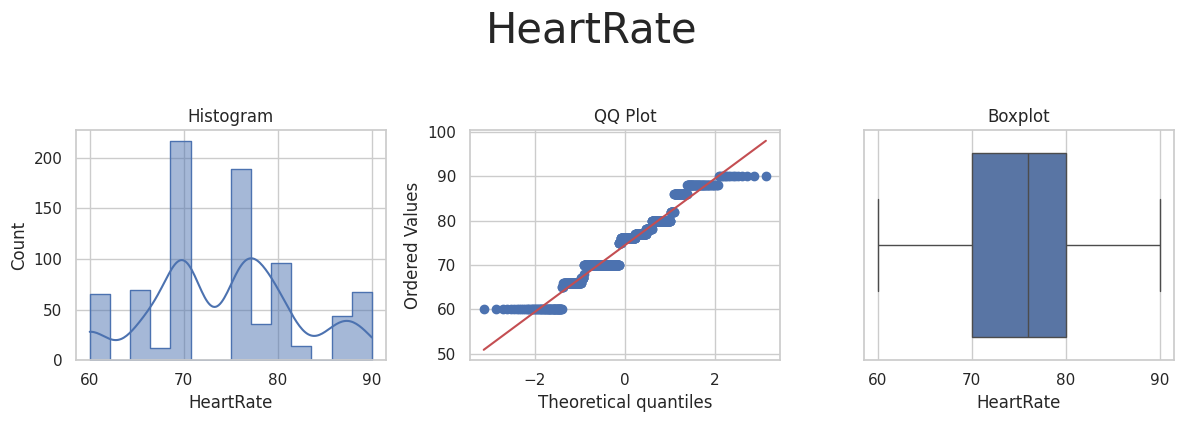

HeartRate  | skewness: 0.05 | kurtosis: -0.53




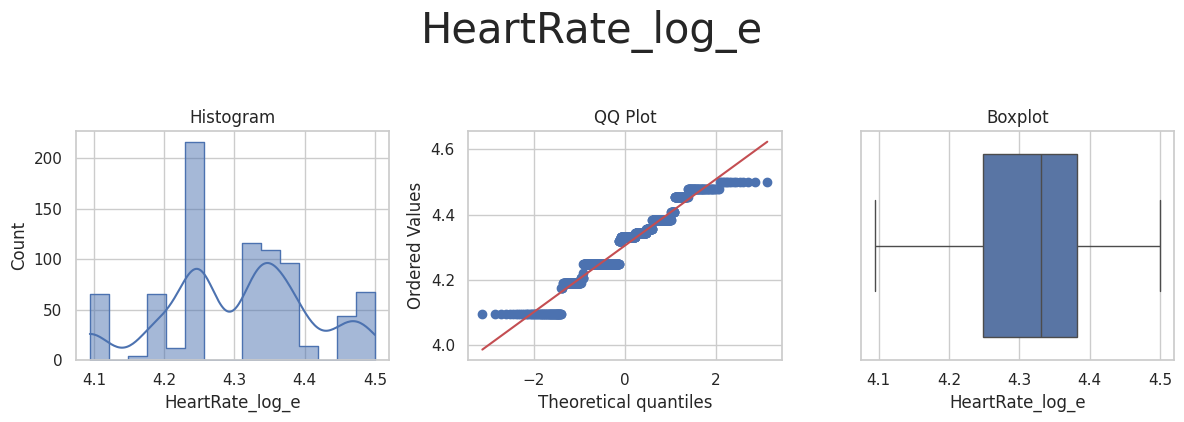

HeartRate_log_e  | skewness: -0.18 | kurtosis: -0.46




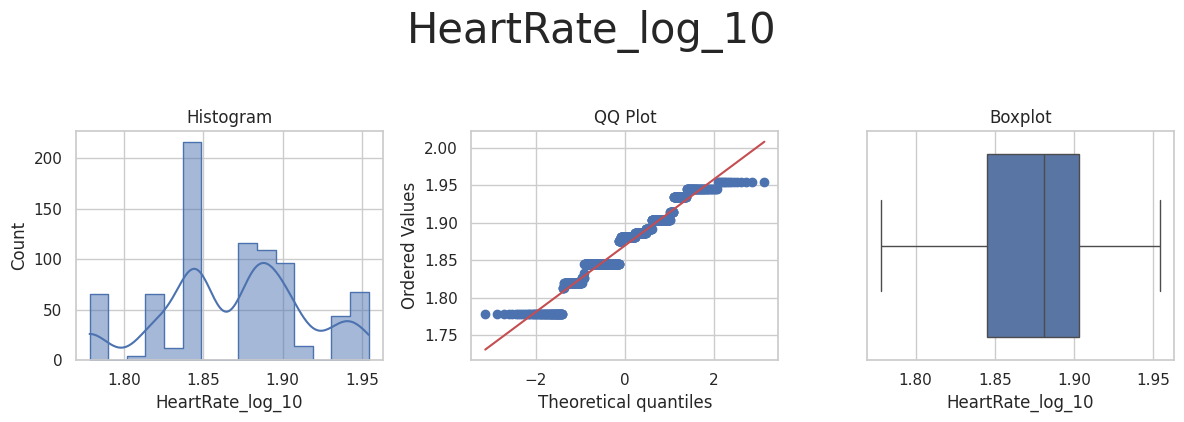

HeartRate_log_10  | skewness: -0.18 | kurtosis: -0.46




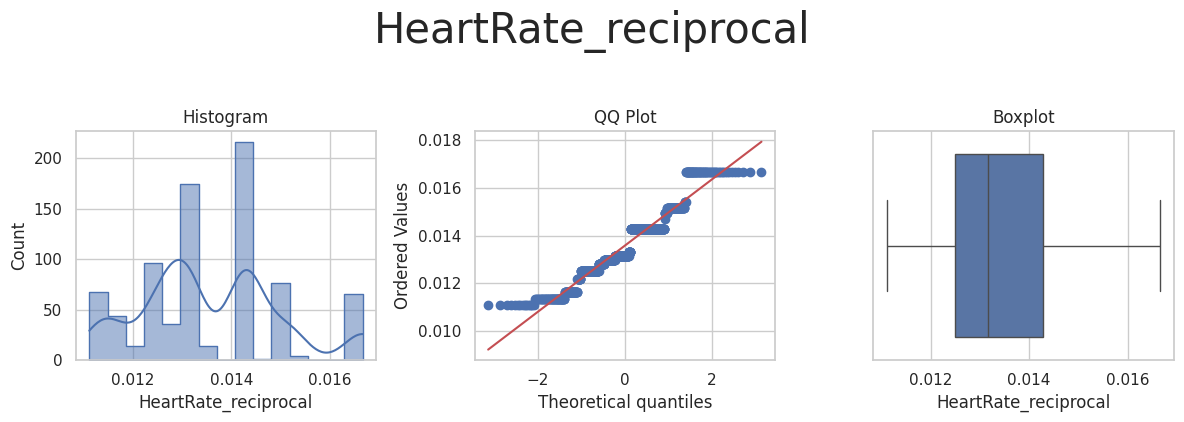

HeartRate_reciprocal  | skewness: 0.42 | kurtosis: -0.27




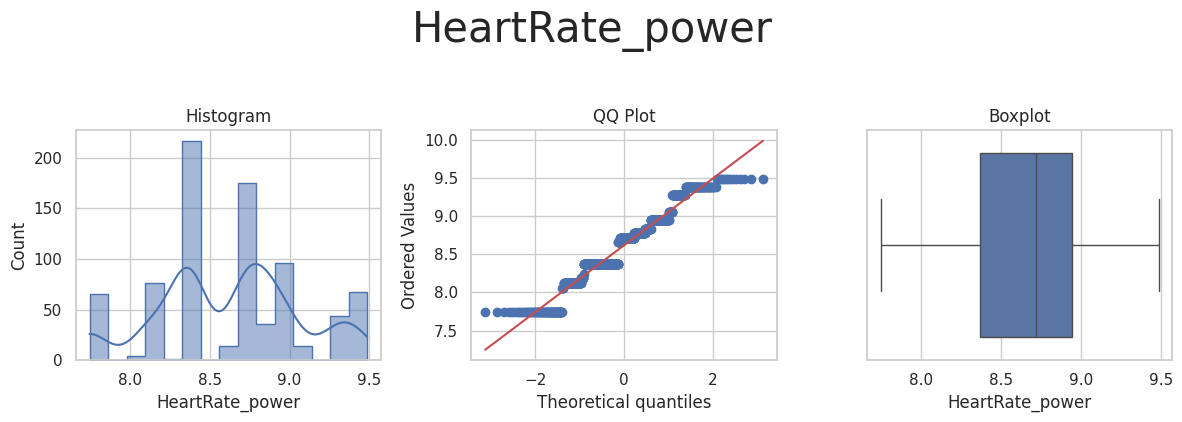

HeartRate_power  | skewness: -0.06 | kurtosis: -0.51




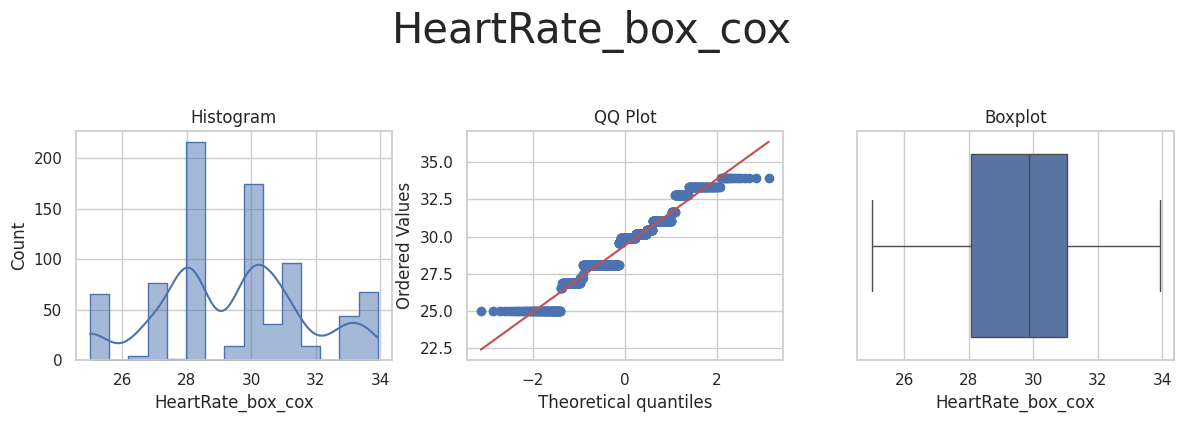

HeartRate_box_cox  | skewness: -0.01 | kurtosis: -0.52




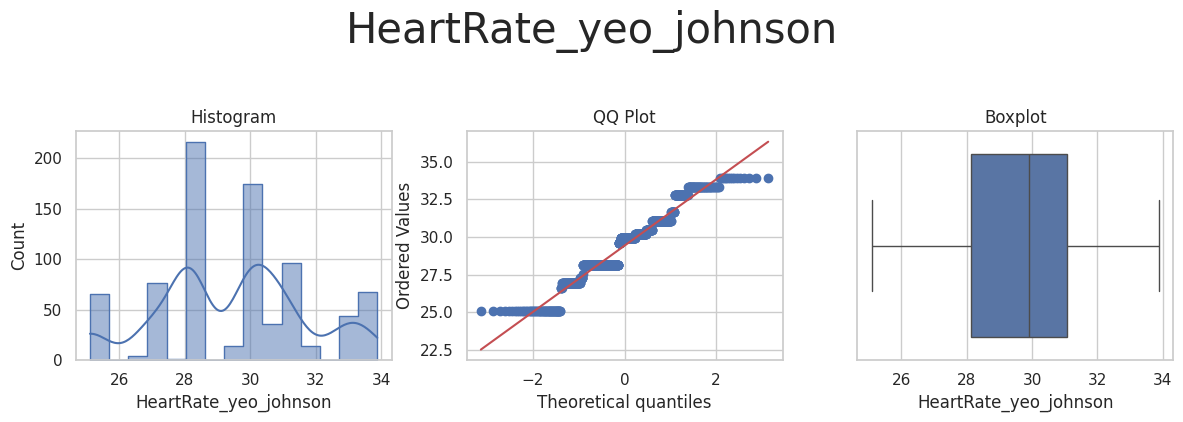

HeartRate_yeo_johnson  | skewness: -0.01 | kurtosis: -0.52




In [69]:
df_feat_eng_num, skew_kurtosis_report_num = FeatureEngineeringAnalysis(df_eng, analysis_type="numerical")

In [70]:
df_feat_eng_num.head()

,Age,Age_log_e,Age_log_10,Age_reciprocal,Age_power,Age_box_cox,Age_yeo_johnson,SystolicBP,SystolicBP_log_e,SystolicBP_log_10,...,BodyTemp_power,BodyTemp_box_cox,BodyTemp_yeo_johnson,HeartRate,HeartRate_log_e,HeartRate_log_10,HeartRate_reciprocal,HeartRate_power,HeartRate_box_cox,HeartRate_yeo_johnson
0,20,2.995732,1.301030,0.050000,4.472136,2.562881,2.462348,120,4.787492,2.079181,...,6.148170,0.010508,0.110704,70,4.248495,1.845098,0.014286,8.366600,28.087043,28.140991
1,30,3.401197,1.477121,0.033333,5.477226,2.850816,2.706091,120,4.787492,2.079181,...,6.188699,0.010508,0.110704,76,4.330733,1.880814,0.013158,8.717798,29.881832,29.907116
2,18,2.890372,1.255273,0.055556,4.242641,2.485992,2.397461,100,4.605170,2.000000,...,6.058052,0.010508,0.110704,76,4.330733,1.880814,0.013158,8.717798,29.881832,29.907116
3,49,3.891820,1.690196,0.020408,7.000000,3.182922,2.987082,140,4.941642,2.146128,...,6.058052,0.010508,0.110704,90,4.499810,1.954243,0.011111,9.486833,33.922448,33.883569
4,28,3.332205,1.447158,0.035714,5.291503,2.802700,2.665322,120,4.787492,2.079181,...,6.058052,0.010508,0.110704,70,4.248495,1.845098,0.014286,8.366600,28.087043,28.140991


### Display the skewness and kurtosis report

In [71]:
skew_kurtosis_report_num

,Feat_Trans,Skewness,Kurtosis
0,Age,0.75,-0.47
1,Age_log_e,0.09,-0.93
2,Age_log_10,0.09,-0.93
3,Age_reciprocal,0.68,-0.07
4,Age_power,0.43,-0.82
5,Age_box_cox,0.01,-0.91
6,Age_yeo_johnson,0.02,-0.92
7,SystolicBP,-0.25,-0.57
8,SystolicBP_log_e,-0.57,-0.46
9,SystolicBP_log_10,-0.57,-0.46


### Summary of Numerical Transformations analysis

From the plots and the skewness and kurtosis summary table, we can draw the following conclusions:

* Age:
  * The age distribution seems to improve slightly with some transformations
  * The distribution and the QQ plot look closer to a normal transformation for the logarithmic transformations as well as Box-Cox and Yeo-Johnson
  * Skewness is close to zero with the Box-Cox transformation, which is a big improvement.
  * Kurtosis has increased in absolute value, but is still in an acceptable range and seems like a trade off that is worth it for the improved skewness.
  * Overall, the distribution looks better after Box-Cox transformation, since it is almost symmetrical
* Systolic BP:
  * Box-Cox and Yeo-Johnson transformation improve skewness significantly and move it close to zero while kurtosis stays almost the same.
  * We chose to apply Box-Cox transformation since we already use it on age
* Diastolic BP:
  * In diastolic BP we do not see any relevant improvements with either of the transformations
  * We will not apply any transformation on Diastolic BP
* Blood Sugar:
  * The blood sugar distribution starts with large skewness and kurtosis levels
  * There are good improvements again with the Box-Cox transformation, as seen in the QQ plot and the skewness and kurtosis summary
  * Although we do not reach a distribution as close to a normal one as the previous features
* Body Temperature:
  * Most of the transformations do not show any notable improvement
  * Even though for the Box-Cox and the Yeo-Johnson transformations we get 0 skewness and kurtosis, when looking at the plots we can see that they did not work
  * The disribution is just a line and the QQ plot collapsed to a horizontal line
  * This could be because the datapoints are very close together to begin with
  * Therefore, we do not transform this feature at all
* Heart Rate:
  * The heartrate distribution has small skewness and moderate kurtosis to begin with
  * Box-Cox and Yeo-Johnson very slightly improve skewness while keeping kurtosis about the same
  * However the improvement is so small that it is not worth transforming this feature

* **Summary**: We plan to apply the following transformations:
  * Box-Cox transformation: `["Age", "SystolicBP", "BloodSugar"]`

### Apply Feature Engineering Analysis Function for Outlier Winsorizer

We have found in the previous notebook that we are interested to handle the outliers in the features `["SystolicBP", "Blood Sugar", "Body Temp"]`

Define a dataframe with only these features to study the effects of outlier winsorization:

In [74]:
train_set

,Age,SystolicBP,DiastolicBP,BloodSugar,BodyTemp,HeartRate,RiskLevel
0,20,120,75,7.01,37.8,70,1
1,30,120,80,9.00,38.3,76,1
2,18,100,70,6.70,36.7,76,0
3,49,140,90,15.00,36.7,90,2
4,28,120,90,6.90,36.7,70,0
...,...,...,...,...,...,...,...
803,19,120,85,9.00,36.7,60,1
804,28,83,60,8.00,38.3,86,2
805,50,140,95,17.00,36.7,60,2
806,13,90,65,7.50,38.3,80,0


In [77]:
df_eng_outliers = train_set.filter(["SystolicBP", "BloodSugar", "BodyTemp"]).copy()
df_eng_outliers.head()

,SystolicBP,BloodSugar,BodyTemp
0,120,7.01,37.8
1,120,9.00,38.3
2,100,6.70,36.7
3,140,15.00,36.7
4,120,6.90,36.7


* Variable Analyzed: SystolicBP
* Applied transformation: ['SystolicBP_iqr'] 



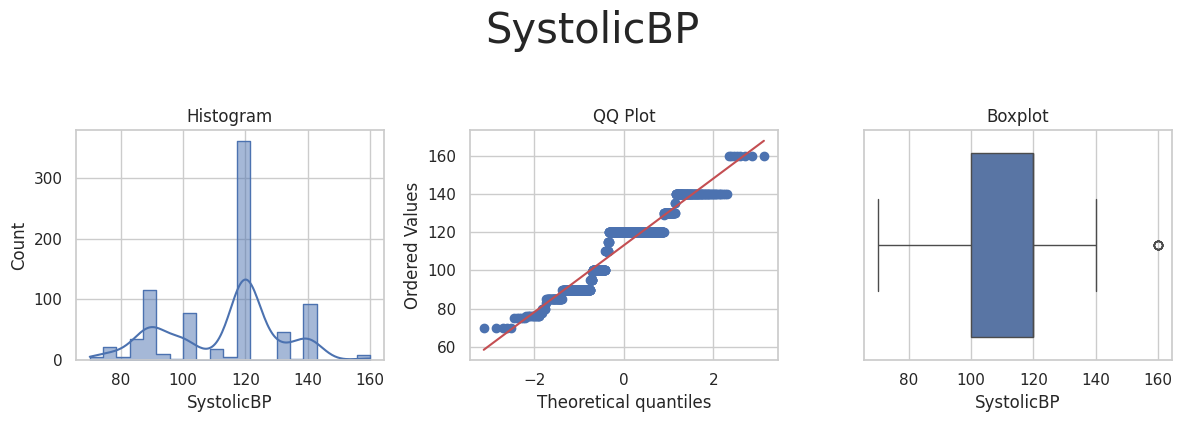

SystolicBP  | skewness: -0.25 | kurtosis: -0.57




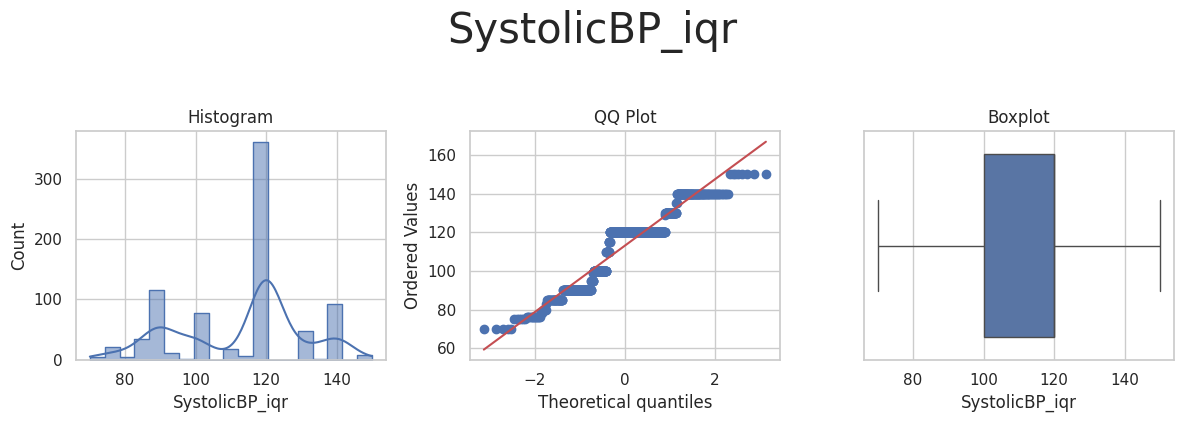

SystolicBP_iqr  | skewness: -0.33 | kurtosis: -0.74


* Variable Analyzed: BloodSugar
* Applied transformation: ['BloodSugar_iqr'] 



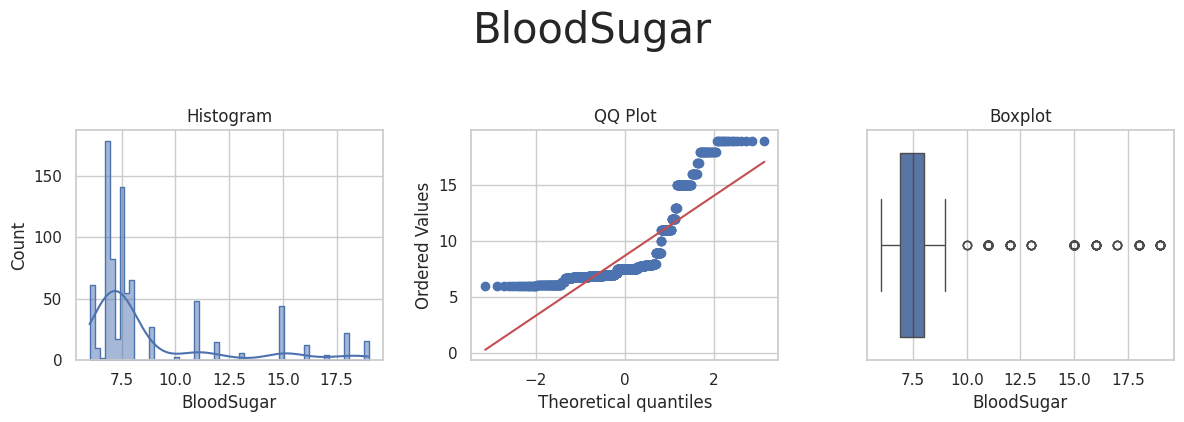

BloodSugar  | skewness: 1.87 | kurtosis: 2.39




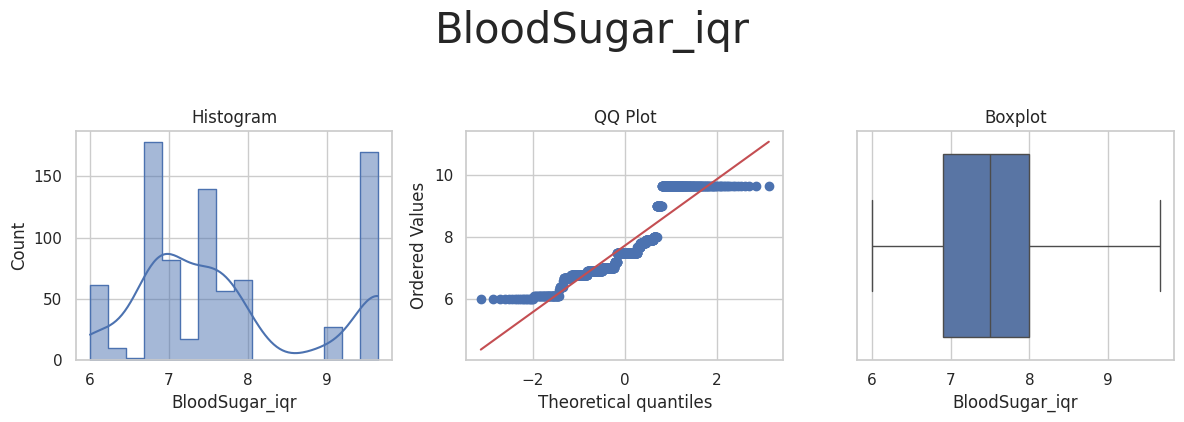

BloodSugar_iqr  | skewness: 0.65 | kurtosis: -0.82


* Variable Analyzed: BodyTemp
* Applied transformation: [] 



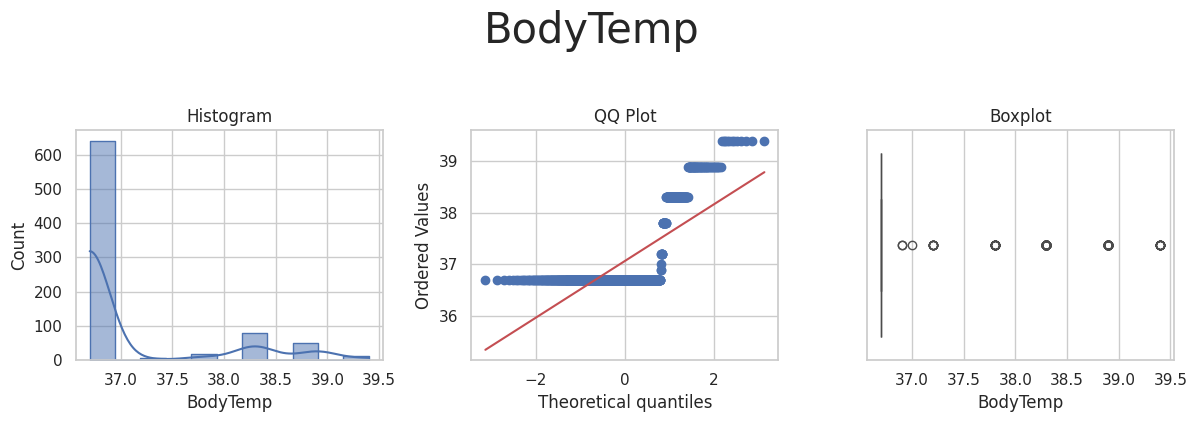

BodyTemp  | skewness: 1.74 | kurtosis: 1.46




In [78]:
df_feat_eng_out, skew_kurtosis_report_out = FeatureEngineeringAnalysis(df_eng_outliers, analysis_type="outlier_winsorizer")

We notice that the distribution shape for BloodSugar and SystolicBP improves with winsorized outliers. We expect this to lead to better model performance due to the reduced impact of extreme values on the model training.

For body temperature the transformation did not work, see also this [GitHub Issue](https://github.com/theresaabl/ML-maternal-health-risk/issues/2). This is due to the very small variance of the data. We thus drip BodyTemp from the Winsorizer transformation feature list.

In conclusion, we will apply Winsorization to `["BloodSugar", "SystolicBP"]`.

---

## Smart Correlated Selection Analysis

We found in the previous notebook that there are several collinearities in this dataset. To avoid potential overfitting and improve model performance we include Smart Correlated Selection into our feature engineering process.

In this notebook we will have a look at the transformation and check which features are selected to be dropped. In the next notebook we will add this to the ML pipeline.

Create a copy of the train set for the feature engineering.

In [98]:
df_eng = train_set.copy()
df_eng.head()

,Age,SystolicBP,DiastolicBP,BloodSugar,BodyTemp,HeartRate,RiskLevel
0,20,120,75,7.01,37.8,70,1
1,30,120,80,9.00,38.3,76,1
2,18,100,70,6.70,36.7,76,0
3,49,140,90,15.00,36.7,90,2
4,28,120,90,6.90,36.7,70,0


Create the SmartCorrelatedSelection object and fit_transform the test set copy.

We use Spearman correlation and choose a threshold of 0.6 to only consider features that are relatively strongly correlated.

In [106]:
corr_selection = SmartCorrelatedSelection(method="spearman", threshold=0.6, selection_method="variance")

corr_selection.fit_transform(df_eng)
corr_selection.correlated_feature_sets_

[{'DiastolicBP', 'SystolicBP'}]

The method found two features that are strongly correlated, which means that one of them would give very similar information about the feature than the other. This could lead to overfitting.

This supports our expectations from previous notebooks that the two blood pressure types will be correlated and thus the one that is less correlated to the target can be dropped.

The feature to be dropped is:

In [107]:
corr_selection.features_to_drop_

['DiastolicBP']

## Push Files to Repo

We generate the following files to save to ouputs and for documentation:



In [42]:
version = 'v1'
file_path = f'outputs/feat_eng/{version}'

try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)

# save plots for documentation
try:
    os.makedirs("documentation/plots")
except Exception as e:
    print(e)

[Errno 17] File exists: 'documentation/plots'


### Distributions Plot

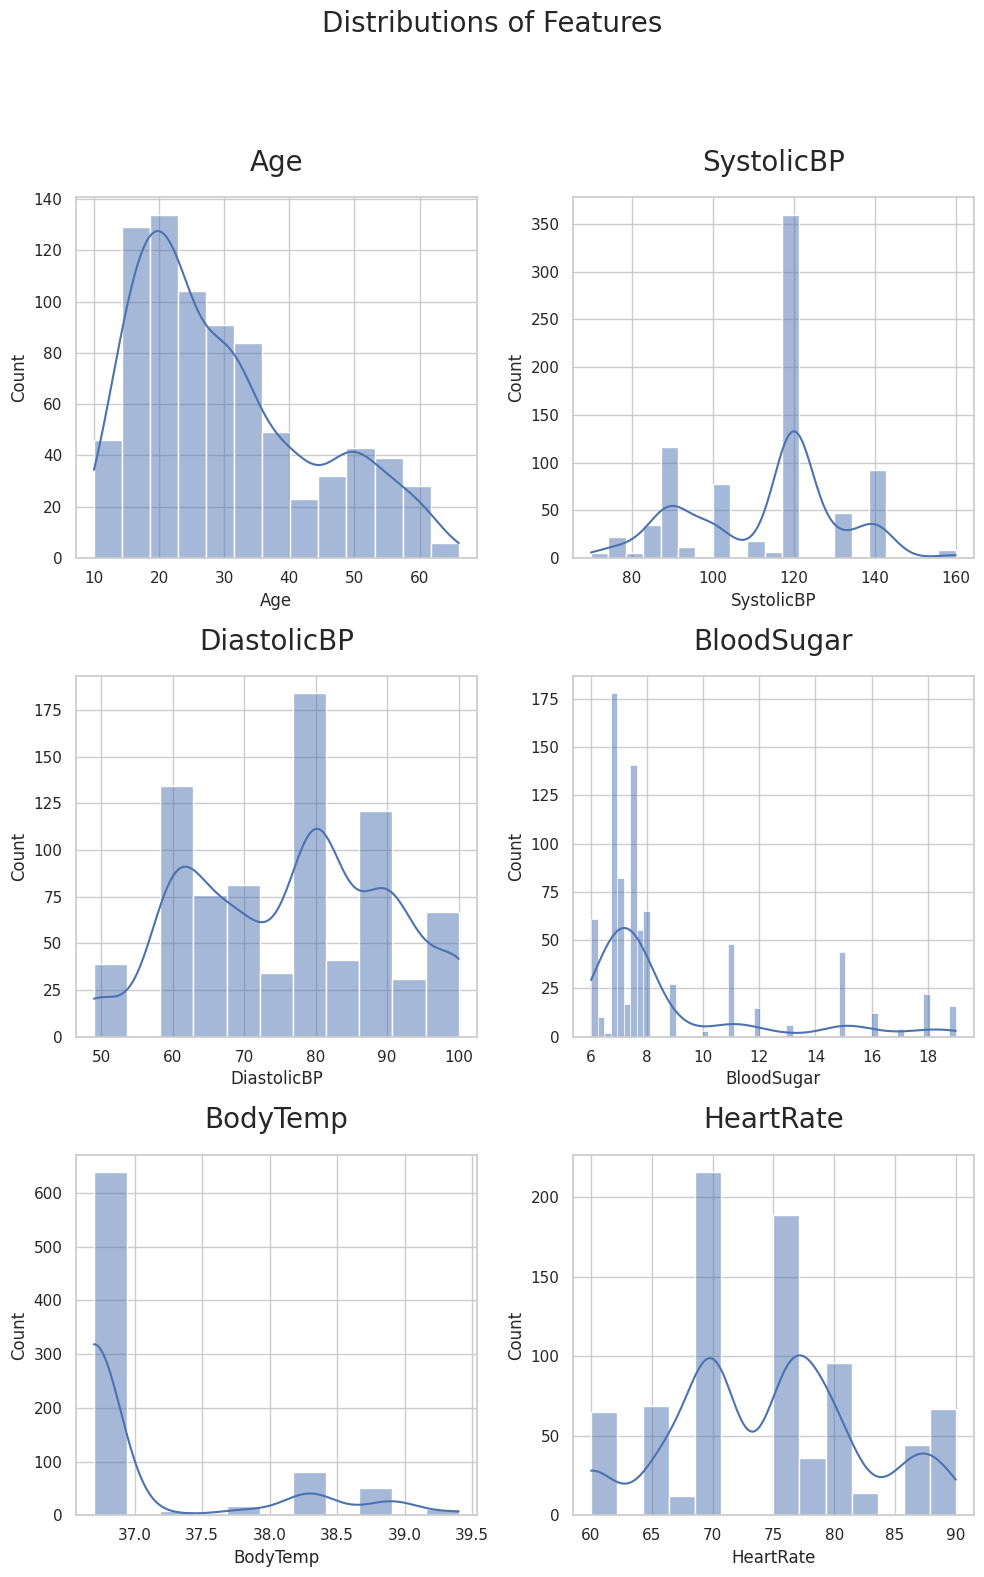

In [41]:
fig_distr

In [43]:
fig_distr.savefig(f'{file_path}/feature_distributions.png', bbox_inches='tight')
fig_distr.savefig(f'documentation/plots/feature_distributions.png', bbox_inches='tight')

---

# Conclusions and Next Steps

* We analysed outlier winsorization on three of our features (the ones with outliers that do not seem to stem from erronous data entries)
  * We find that we will apply the Winsorizer to BloodSugar and SystolicBP
* We analysed six different numerical transformations on our six features and decided to include into our feature engineering pipeline:
  * Box-Cox transformation on the following features: Age, Systolic BP, Blood Sugar
* We also looked into Smart Correlated Selection and found:
  * The DiastolicBP feature is strongly correlated to SystolicBP and can thus be dropped

We will include these transformations in the feature engineering pipeline in the next notebook:

* Winsorization: `["BloodSugar", "SystolicBP"]`
* Box-Cox transformation: `["Age", "SystolicBP", "BloodSugar"]`
* SmartCorrelatedSelection: drops `["DiastolicBP"]`